# Project Introduction: Integrating Moving Average (MA) Crossover and Average Directional Index (ADX) for Stock Analysis

## Objective
The objective of this project is to develop a reliable stock screening tool that identifies potential buy and sell signals using two powerful technical indicators: the Moving Average (MA) Crossover and the Average Directional Index (ADX). By combining these indicators, we aim to enhance the accuracy of our signals, leveraging the strengths of both trend identification and trend strength analysis.

## Background
Technical analysis involves using historical price and volume data to forecast future price movements. Among the myriad of technical indicators available, the MA Crossover and ADX are two widely respected tools that traders use to assess market conditions.

## Why Moving Average Crossover and ADX?

### Moving Average (MA) Crossover
- **Purpose:** The MA Crossover is used to identify potential trend reversals by examining the crossing points of different moving averages.
- **Components:**
  - **Short-Term MA:** A moving average calculated over a shorter period (e.g., 20-day MA).
  - **Long-Term MA:** A moving average calculated over a longer period (e.g., 100-day MA).
- **Signals:**
  - **Potential Bullish Trend Reversal:** Occurs when the short-term MA crosses above the long-term MA, indicating a potential buy signal.
  - **Potential Bearish Trend Reversal:** Occurs when the short-term MA crosses below the long-term MA, indicating a potential sell signal.

### Average Directional Index (ADX)
- **Purpose:** The ADX is used to quantify the strength of a trend, regardless of its direction. It helps traders understand whether a market is trending or ranging.
- **Components:**
  - **ADX Line:** Indicates the strength of a trend. A value above 25 typically signifies a strong trend, while a value below 20 indicates a weak or non-trending market.
  - **Plus Directional Indicator (+DI):** Measures the presence of upward trend movement.
  - **Minus Directional Indicator (-DI):** Measures the presence of downward trend movement.
- **Signals:**
  - **Strong Trend:** ADX above 25.
  - **Weak Trend:** ADX below 20.

## Combining Moving Average Crossover and ADX
Using these indicators together can help confirm signals and reduce false positives:
- **Enhanced Accuracy:** While the MA Crossover helps identify trend reversals, ADX provides insight into the strength of the trend, filtering out weak signals in low trend strength environments.
- **Filter for False Signals:** The MA Crossover can sometimes give premature signals in weak trends. By requiring confirmation through ADX's trend strength measure, we filter out some of these false signals, increasing the likelihood that our signals are accurate.

## Methodology

- **Data Collection:** We collect historical price data for a selection of stocks over a specified period.
- **Indicator Calculation:** We calculate the MA Crossover and ADX for each stock.
- **Stock Screening:** We screen stocks based on the following criteria:
  - **Buy Criteria:** Short-term MA crosses above the long-term MA (Potential Bullish Trend Reversal), with ADX above 20 indicating a strong trend.
  - **Sell Criteria:** Short-term MA crosses below the long-term MA (Potential Bearish Trend Reversal), with ADX above 20 indicating a strong trend.
- **Visualization and Export:** We visualize the results and export the screened stocks to a CSV file for further analysis.

## Data Source and Flexibility
In this analysis, we will be using data from the FTSE 250 companies. However, feel free to use any dataset you prefer by simply changing the CSV file name in the script. Ensure that your dataset contains a column named "Ticker".

## Conclusion
This project aims to leverage the complementary strengths of the MA Crossover and ADX to create an intriguing stock screening tool. By considering both trend identification and trend strength, our signals offer interesting insights designed to inspire further analysis. The chosen thresholds and periods are standard and widely accepted in technical analysis, providing a thought-provoking starting point for potential future exploration.


In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
import contextlib
import sys
import os

# Function to suppress print statements
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Function to calculate Moving Averages and detect crossovers
def calculate_moving_averages(data, short_window=10, long_window=50):
    data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window).mean()
    data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1, 0)
    data['Crossover'] = data['Signal'].diff()
    return data

# Function to calculate ADX (Average Directional Index)
def calculate_adx(data, window=14):
    data['High_Low'] = data['High'] - data['Low']
    data['High_PrevClose'] = np.abs(data['High'] - data['Close'].shift())
    data['Low_PrevClose'] = np.abs(data['Low'] - data['Close'].shift())
    data['True_Range'] = data[['High_Low', 'High_PrevClose', 'Low_PrevClose']].max(axis=1)
    
    data['UpMove'] = data['High'] - data['High'].shift()
    data['DownMove'] = data['Low'].shift() - data['Low']
    data['Plus_DM'] = np.where((data['UpMove'] > data['DownMove']) & (data['UpMove'] > 0), data['UpMove'], 0)
    data['Minus_DM'] = np.where((data['DownMove'] > data['UpMove']) & (data['DownMove'] > 0), data['DownMove'], 0)
    
    data['ATR'] = data['True_Range'].rolling(window=window).mean()
    data['Smooth_Plus_DM'] = data['Plus_DM'].rolling(window=window).mean()
    data['Smooth_Minus_DM'] = data['Minus_DM'].rolling(window=window).mean()
    
    data['Plus_DI'] = (data['Smooth_Plus_DM'] / data['ATR']) * 100
    data['Minus_DI'] = (data['Smooth_Minus_DM'] / data['ATR']) * 100
    
    data['DX'] = np.abs(data['Plus_DI'] - data['Minus_DI']) / (data['Plus_DI'] + data['Minus_DI']) * 100
    
    data['ADX'] = data['DX'].rolling(window=window).mean()
    
    data.drop(['High_Low', 'High_PrevClose', 'Low_PrevClose', 'True_Range', 'UpMove', 'DownMove',
               'Plus_DM', 'Minus_DM', 'ATR', 'Smooth_Plus_DM', 'Smooth_Minus_DM', 'Plus_DI', 'Minus_DI', 'DX'], axis=1, inplace=True)
    
    return data

# Function to analyze stock for crossovers and ADX trend strength
def analyze_stock_ma_adx(symbol):
    try:
        end_date = datetime.now() - timedelta(days=1)
        start_date = end_date - timedelta(days=9*30)  
        
        with suppress_output():
            data = yf.download(symbol, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        
        if data.empty:
            print(f"No data fetched for {symbol}")
            return {"Symbol": symbol, "Data": pd.DataFrame()}

        data = calculate_moving_averages(data)
        data = calculate_adx(data)
        data.dropna(subset=['Short_MA', 'Long_MA', 'Crossover', 'ADX'], inplace=True)

        if data.empty:
            print(f"Insufficient data after calculating indicators for {symbol}")
            return {"Symbol": symbol, "Data": pd.DataFrame()}

        recent_crossover = data['Crossover'].iloc[-5:].values
        recent_adx = data['ADX'].iloc[-5:]
        bullish_trend_change = 1 in recent_crossover
        bearish_trend_change = -1 in recent_crossover
        strong_trend = data['ADX'].iloc[-1] > 25

        meets_criteria = (bullish_trend_change or bearish_trend_change) and strong_trend

        return {
            "Symbol": symbol,
            "Short_MA": data['Short_MA'].iloc[-1],
            "Long_MA": data['Long_MA'].iloc[-1],
            "ADX": data['ADX'].iloc[-1],
            "Bullish Trend Change": bullish_trend_change,
            "Bearish Trend Change": bearish_trend_change,
            "Strong Trend": strong_trend,
            "Meets Criteria": meets_criteria,
            "Data": data
        }

    except Exception as e:
        print(f"Error analyzing stock {symbol}: {e}")
        return {"Symbol": symbol, "Data": pd.DataFrame()}

# Load tickers from the CSV file
tickers_df = pd.read_csv('ftse_250_tickers.csv')
symbols = tickers_df['Ticker'].tolist()

# Initialize list to store results
results = []

# Analyze each stock
for symbol in tqdm(symbols, desc="Processing stocks"):
    stock_data = analyze_stock_ma_adx(symbol)
    if stock_data is not None and stock_data["Meets Criteria"]:
        results.append(stock_data)

# Convert results to DataFrame
results_df = pd.DataFrame([{
    "Symbol": r["Symbol"],
    "Short_MA": r["Short_MA"],
    "Long_MA": r["Long_MA"],
    "ADX": r["ADX"],
    "Bullish Trend Change": r["Bullish Trend Change"],
    "Bearish Trend Change": r["Bearish Trend Change"],
    "Strong Trend": r["Strong Trend"],
    "Meets Criteria": r["Meets Criteria"]
} for r in results])

# Export results to CSV
results_df.to_csv("ma_cross_adx_filtered_results.csv", index=False)

# Print results
results_df


Processing stocks: 100%|█████████████████████████████████████████████████████████████| 247/247 [00:31<00:00,  7.94it/s]


Symbol     Short_MA      Long_MA        ADX  Bullish Trend Change  \
0    CBG.L   490.379999   466.532000  48.048886                  True   
1   DSCV.L   722.500000   718.300000  30.472208                  True   
2    JUP.L    84.800000    81.748000  43.942411                  True   
3    MRC.L   244.200000   239.040000  56.444988                  True   
4    SNR.L   165.140001   163.787999  28.888940                  True   
5   SUPR.L    74.620000    73.748000  42.476162                  True   
6    TUI.L   524.813500   565.042700  33.307907                 False   
7    CHG.L   386.400000   383.900000  28.601914                  True   
8    SCT.L  1638.600000  1699.360000  61.894525                 False   
9   ATST.L  1220.600000  1217.000000  49.257410                  True   
10  EDIN.L   740.000000   732.340000  32.726255                  True   
11  MRCH.L   583.100000   575.160000  28.799379                  True   
12   GRG.L  2876.000000  2846.400000  26.184965                  True   
13   UKW.L   138.280002   137.668000  50.951268                  True   
14  TCAP.L   214.800000   211.666000  42.370514                  True   
15  TMPL.L   269.600000   266.790000  30.748674                  True   
16  BYIT.L   518.099997   542.005999  27.121383                 False   
17  VMUK.L   214.300000   213.972001  38.570750                  True   
18  LWDB.L   888.700000   870.460000  48.576948                  True   
19  THRG.L   634.700000   621.940000  32.900386                  True   
20   NAS.L  4058.000000  4016.600000  32.384291                  True   
21   MUT.L   877.300000   871.040000  27.654781                  True   
22  ESCT.L   185.000000   183.744001  46.340787                  True   
23  INCH.L   807.800000   789.470000  42.795272                  True   
24   TRY.L   330.200000   326.590000  34.689214                  True   
25  BGEO.L  4351.500000  4097.200000  62.112537                  True   
26  TRIG.L    98.570000    98.566000  44.163565                  True   
27  BRGE.L   628.400000   625.240000  29.079915                  True   
28   RDW.L   702.300000   698.820000  29.161744                  True   
29   GEN.L   469.250000   452.860000  53.231405                  True   
30   VTY.L  1302.600000  1260.220000  62.150910                  True   
31  BRSC.L  1504.200000  1476.960000  37.093794                  True   
32   TPK.L   859.850000   829.640000  39.462301                  True   
33   HGT.L   499.700000   488.500000  30.704942                  True   
34   COA.L    85.140000    84.120000  31.121706                  True   
35   RCP.L  1897.200000  1855.920000  67.321761                  True   
36   KIE.L   150.179999   143.599999  38.244008                  True   
37   PHP.L    94.665000    93.454001  57.207080                  True   
38   FGP.L   170.830000   166.370000  37.471912                  True   

    Bearish Trend Change  Strong Trend  Meets Criteria  
0                  False          True            True  
1                  False          True            True  
2                  False          True            True  
3                  False          True            True  
4                  False          True            True  
5                  False          True            True  
6                   True          True            True  
7                  False          True            True  
8                   True          True            True  
9                  False          True            True  
10                 False          True            True  
11                 False          True            True  
12                 False          True            True  
13                 False          True            True  
14                 False          True            True  
15                 False          True            True  
16                  True          True            True  
17                 False          True            True  


In [40]:
# Calculate and print the detailed results
total_tickers = len(tickers_df)
tickers_meeting_criteria = len(results_df)
percentage_meeting_criteria = (tickers_meeting_criteria / total_tickers) * 100

# Print results
print("My preference is a 5-20% threshold which strikes a balance, ensuring a\nfocused yet diverse selection of stocks to allow further investigations.")
print(f"Tickers meeting criteria: {tickers_meeting_criteria}")
print(f"Percentage of shares that pass the criteria: {percentage_meeting_criteria:.2f}%")

# Determine if the percentage is within the desired filter range
if 5 <= percentage_meeting_criteria <= 20:
    print("The percentage of shares meeting the criteria is within the desirable range (5-20%).")
else:
    print("The percentage of shares meeting the criteria is outside the desirable range (5-15%).")

My preference is a 5-20% threshold which strikes a balance, ensuring a
focused yet diverse selection of stocks to allow further investigations.
Tickers meeting criteria: 39
Percentage of shares that pass the criteria: 15.79%
The percentage of shares meeting the criteria is within the desirable range (5-20%).


The following stocks have met the specified criteria. A plot is displayed showing the stock price and its relationship to the associated indicators. Additionally, detailed financial and company information is provided for each stock.



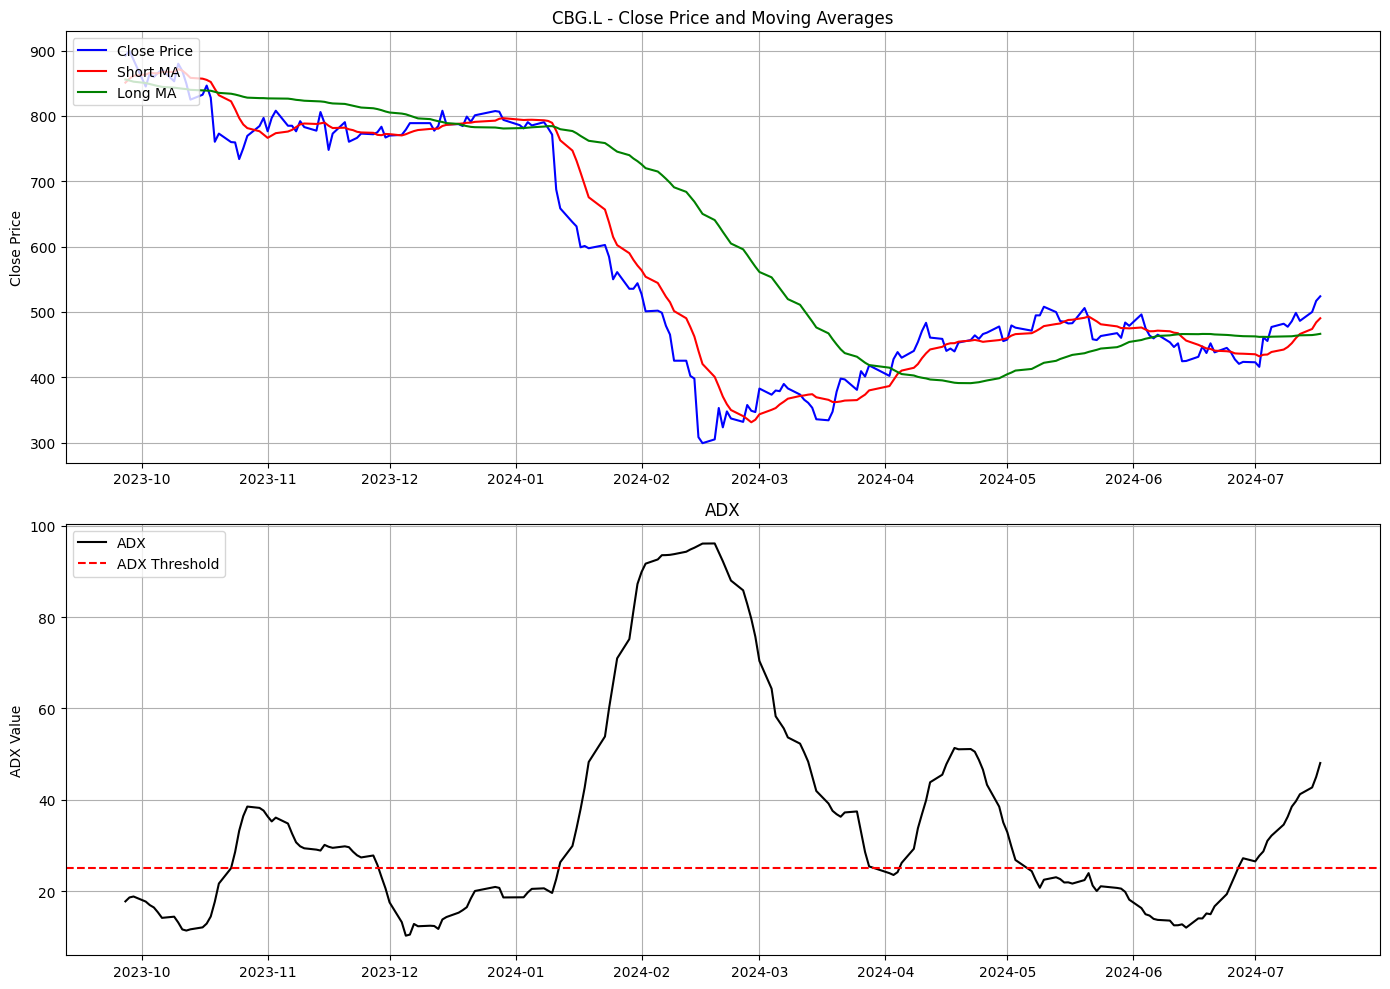

Ticker:                   CBG.L
Company:                  CLOSE BROTHERS GROUP PLC ORD 25
Sector:                   Financial Services
Industry:                 Banks - Regional
Market Cap:               £784,042,496
Shares Outstanding:       150,488,000
52-Week High:             979.0
52-Week Low:              278.0
PE Ratio (TTM):           5.4842105
EPS (TTM):                0.95
Dividend Yield:           0.1696
Payout Ratio:             0.71349996
Revenue (TTM):            £925,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £141,500,000
Total Debt:               £2,653,700,096
Operating Cash Flow (TTM): £-1,204,899,968
Free Cash Flow (TTM):     N/A

Description:              Close Brothers Group plc, a merchant banking company, engages in the provision of financial services to small businesses and individuals in the United Kingdom. It operates through five segments: Commercial, Retail, Property, Asset Management, and Securities. The company offers banking services 

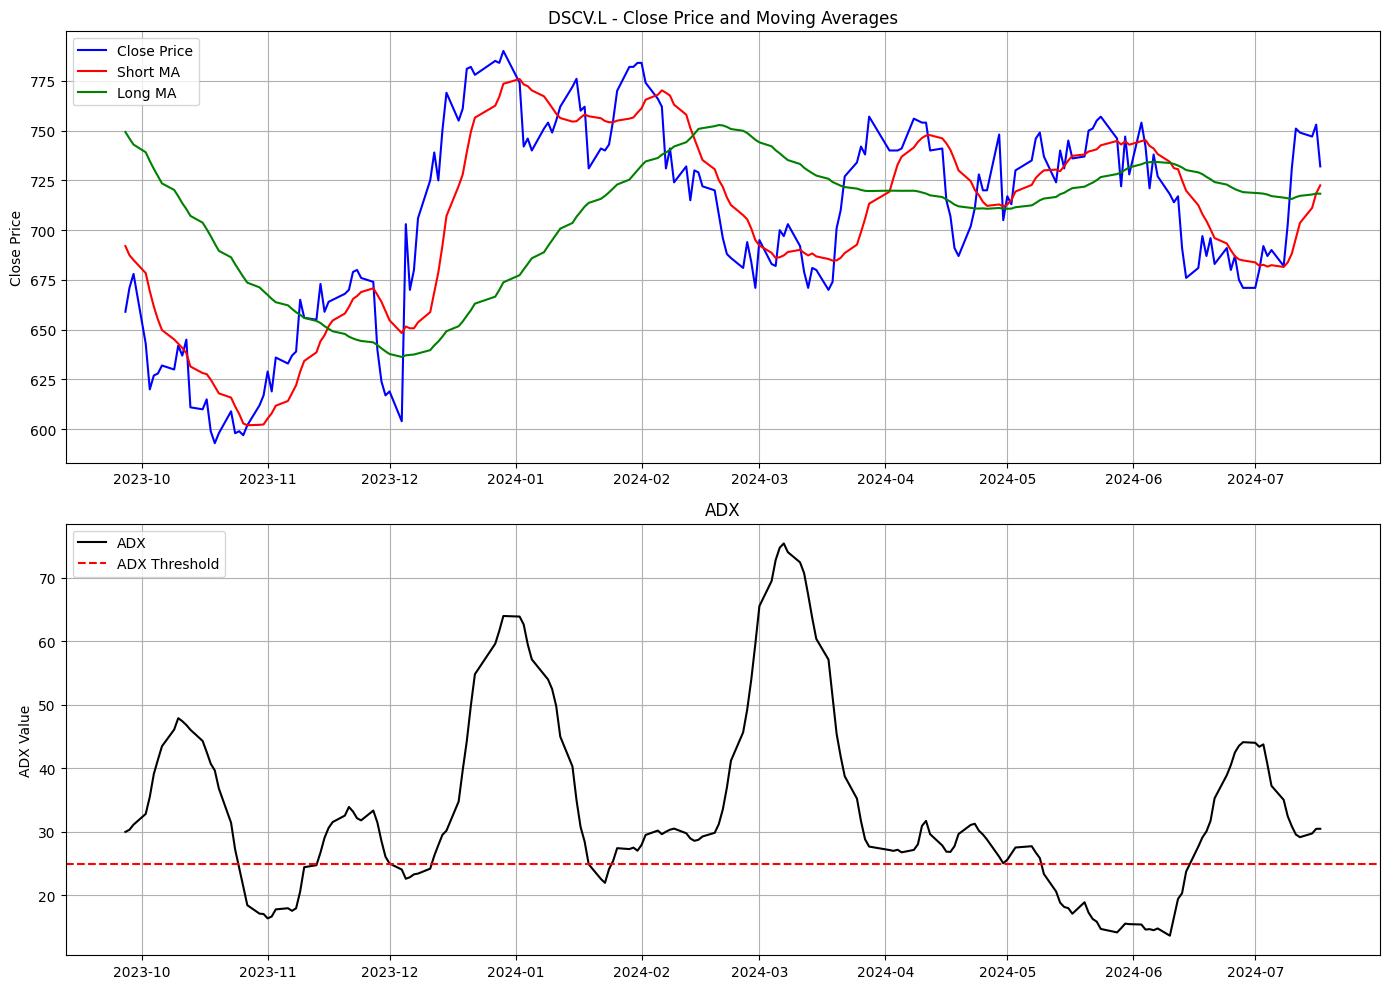

Ticker:                   DSCV.L
Company:                  DISCOVERIE GROUP PLC ORD 5P
Sector:                   Technology
Industry:                 Electronic Components
Market Cap:               £700,372,992
Shares Outstanding:       95,941,504
52-Week High:             873.0
52-Week Low:              586.0
PE Ratio (TTM):           45.625004
EPS (TTM):                0.16
Dividend Yield:           0.0162
Payout Ratio:             0.73730004
Revenue (TTM):            £437,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £15,500,000
Total Debt:               £234,900,000
Operating Cash Flow (TTM): £41,200,000
Free Cash Flow (TTM):     £26,862,500

Description:              discoverIE Group plc designs, manufactures, and supplies components for electronic applications worldwide. It operates in two segments, Magnetics & Controls; and Sensing & Connectivity. The company offers magnetic and power components, embedded computing and interface controls, and sensing and connec

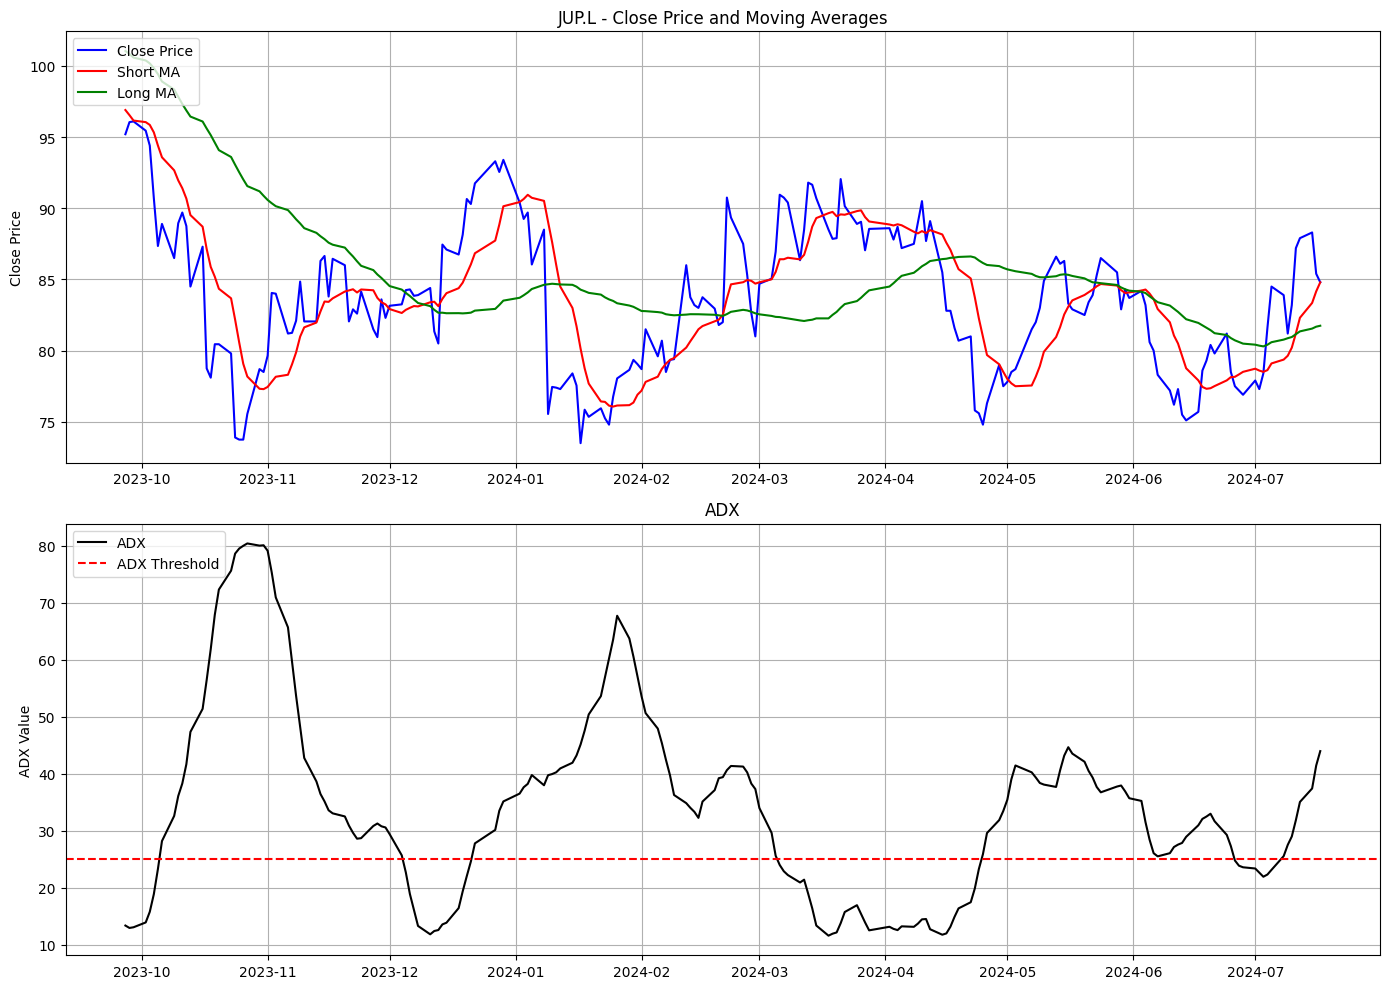

Ticker:                   JUP.L
Company:                  JUPITER FUND MANAGEMENT PLC ORD
Sector:                   Financial Services
Industry:                 Asset Management
Market Cap:               £433,395,872
Shares Outstanding:       511,080,000
52-Week High:             128.3
52-Week Low:              71.1
PE Ratio (TTM):           N/A
EPS (TTM):                -0.02
Dividend Yield:           0.0793
Payout Ratio:             0.77059996
Revenue (TTM):            £368,800,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £-12,900,000
Total Debt:               £93,800,000
Operating Cash Flow (TTM): £88,000,000
Free Cash Flow (TTM):     £127,800,000

Description:              Jupiter Fund Management Plc is a publicly owned investment manager. The firm manages mutual funds, hedge funds, client focused portfolios, and multi-manager products for its clients. It invests in the public equity markets across U.K., Europe and global emerging markets. The firm also invests in fi

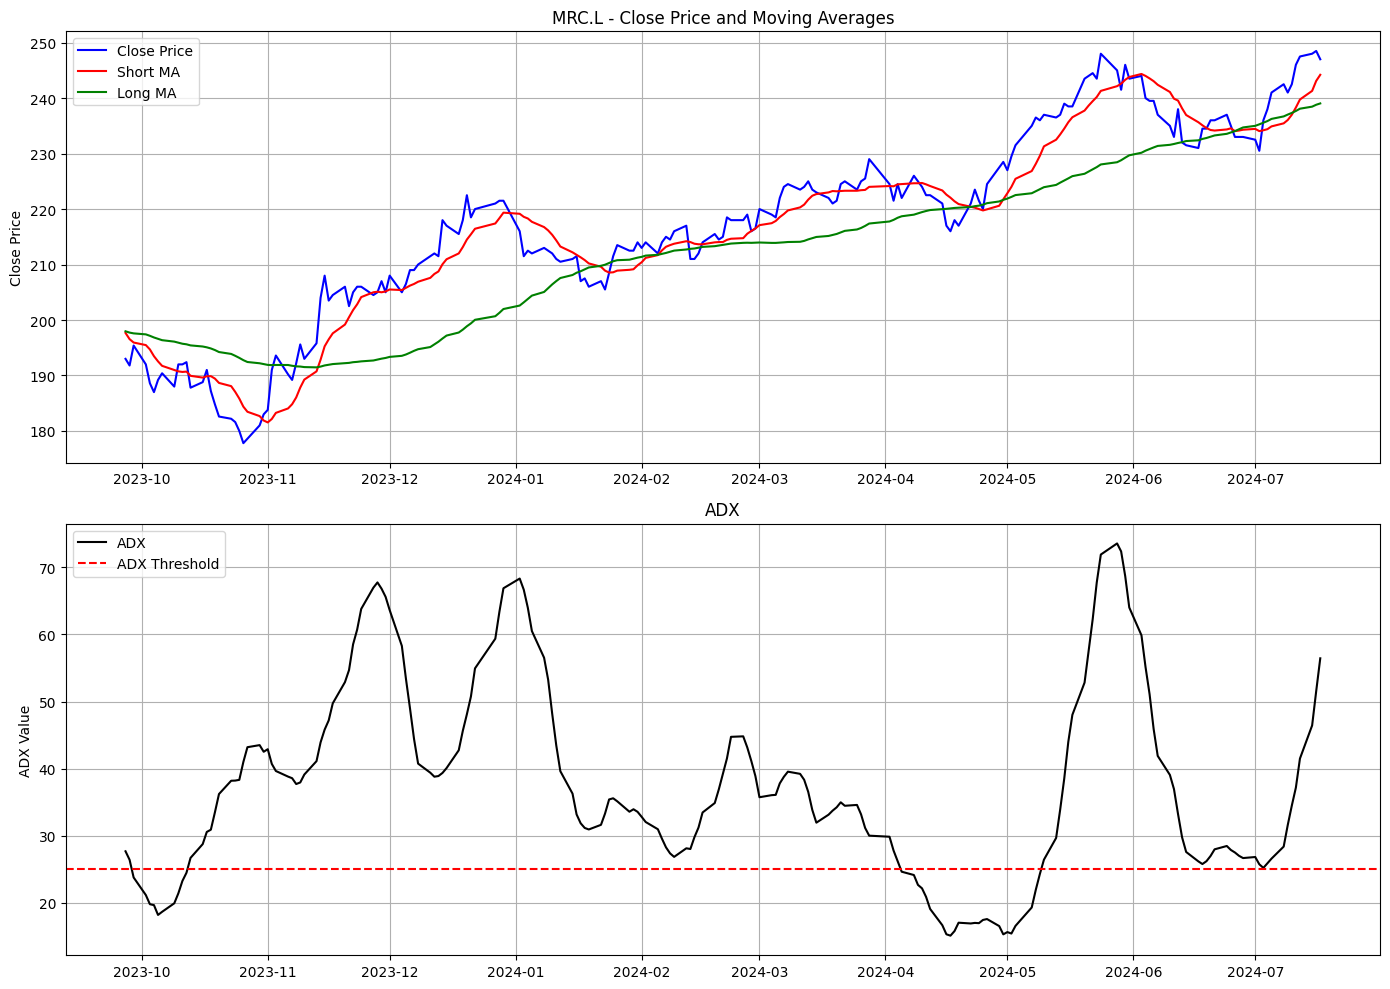

Ticker:                   MRC.L
Company:                  MERCANTILE INVESTMENT TRUST (TH
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,929,252,096
Shares Outstanding:       N/A
52-Week High:             251.56
52-Week Low:              177.2
PE Ratio (TTM):           24.9
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


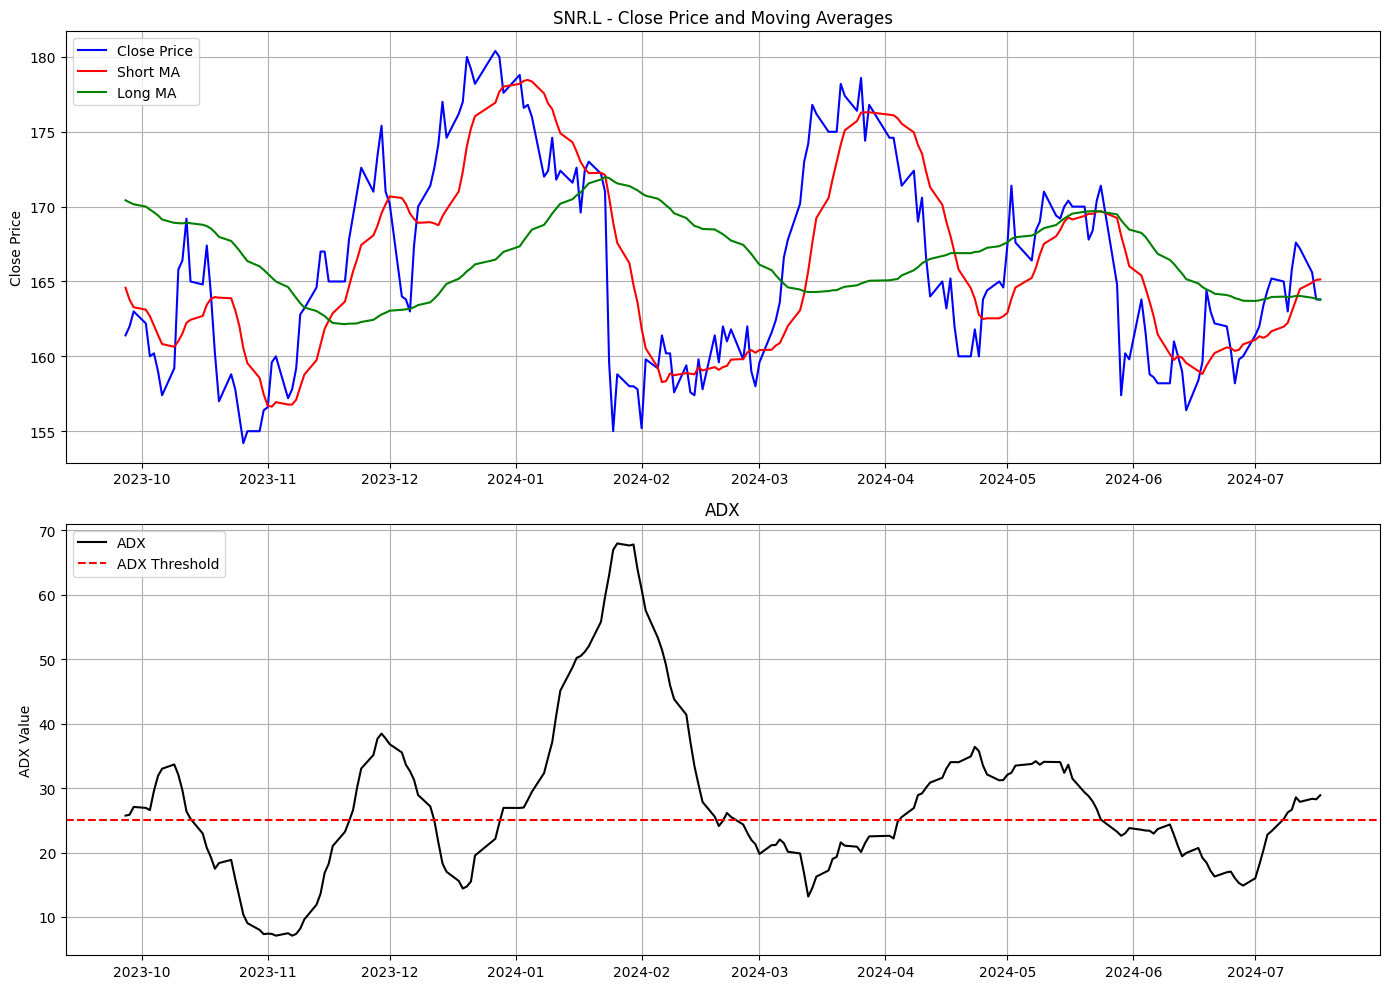

Ticker:                   SNR.L
Company:                  SENIOR PLC ORD 10P
Sector:                   Industrials
Industry:                 Aerospace & Defense
Market Cap:               £665,206,272
Shares Outstanding:       412,659,008
52-Week High:             183.0
52-Week Low:              146.8
PE Ratio (TTM):           23.028572
EPS (TTM):                0.07
Dividend Yield:           0.014099999
Payout Ratio:             0.2186
Revenue (TTM):            £963,500,032
Gross Profit (TTM):       N/A
Net Income (TTM):         £31,100,000
Total Debt:               £251,400,000
Operating Cash Flow (TTM): £41,400,000
Free Cash Flow (TTM):     £-26,662,500

Description:              Senior plc designs, manufactures, and sells high-technology components and systems for the principal original equipment manufacturers in the aerospace, defense, land vehicle, and power and energy markets in the United States, the United Kingdom, and internationally. It operates in two segments, Aerospace and

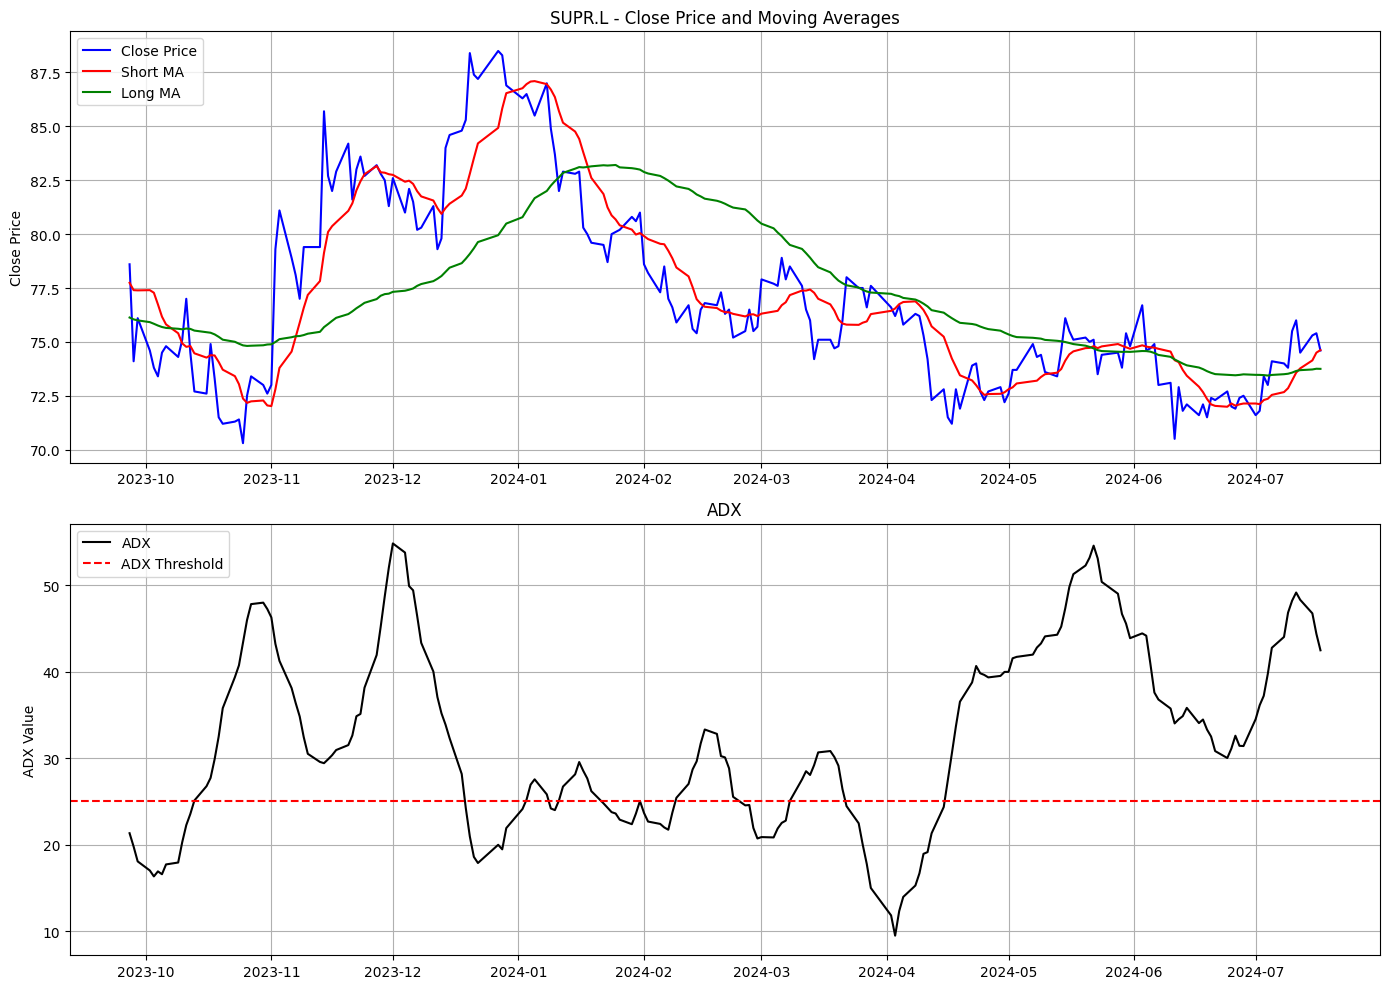

Ticker:                   SUPR.L
Company:                  SUPERMARKET INCOME REIT PLC ORD
Sector:                   N/A
Industry:                 N/A
Market Cap:               £930,866,560
Shares Outstanding:       N/A
52-Week High:             88.8
52-Week Low:              69.5
PE Ratio (TTM):           Infinity
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


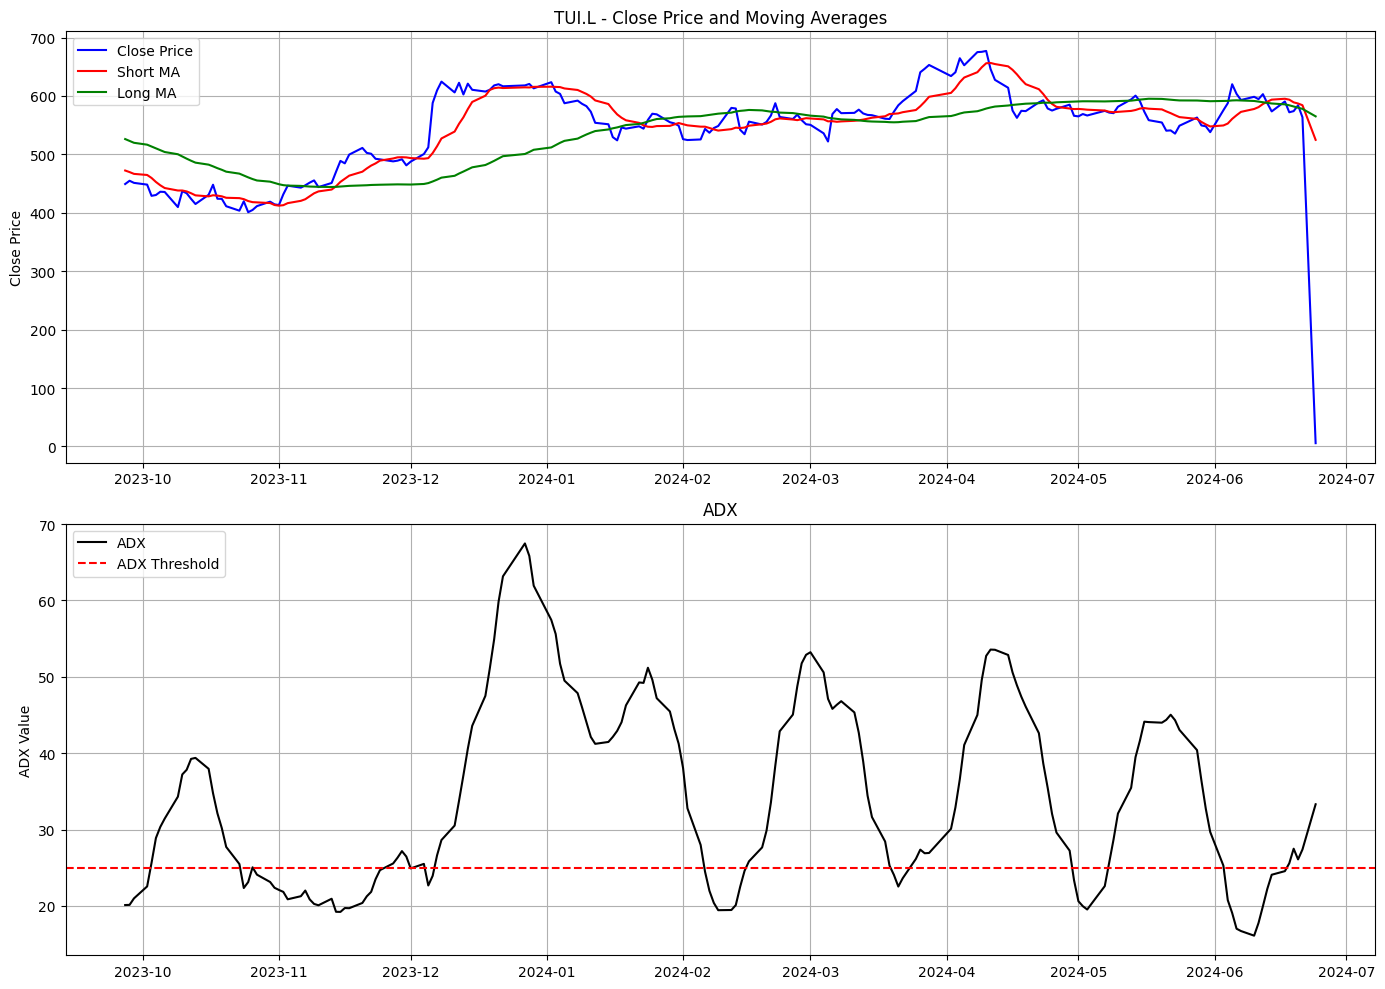

Ticker:                   TUI.L
Company:                  TUI AG ORD REG SHS NPV (DI)
Sector:                   Consumer Cyclical
Industry:                 Travel Services
Market Cap:               £2,901,760,000
Shares Outstanding:       507,431,008
52-Week High:             687.0
52-Week Low:              0.0
PE Ratio (TTM):           3.2017047
EPS (TTM):                1.76
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £21,714,999,296
Gross Profit (TTM):       N/A
Net Income (TTM):         £509,400,000
Total Debt:               £4,792,099,840
Operating Cash Flow (TTM): £1,653,200,000
Free Cash Flow (TTM):     £-271,837,504

Description:              TUI AG, together with its subsidiaries, provides tourism services worldwide. It operates hotels and resorts under the Royalton, Mora, RIU Hotels & Resorts, Robinson, TUI Blue, TUI Magic Life, Atlantica Hotels & Resorts, Grupotel, Iberotel, Akra Hotels, TUI Suneo, and AQI brands. The company is also

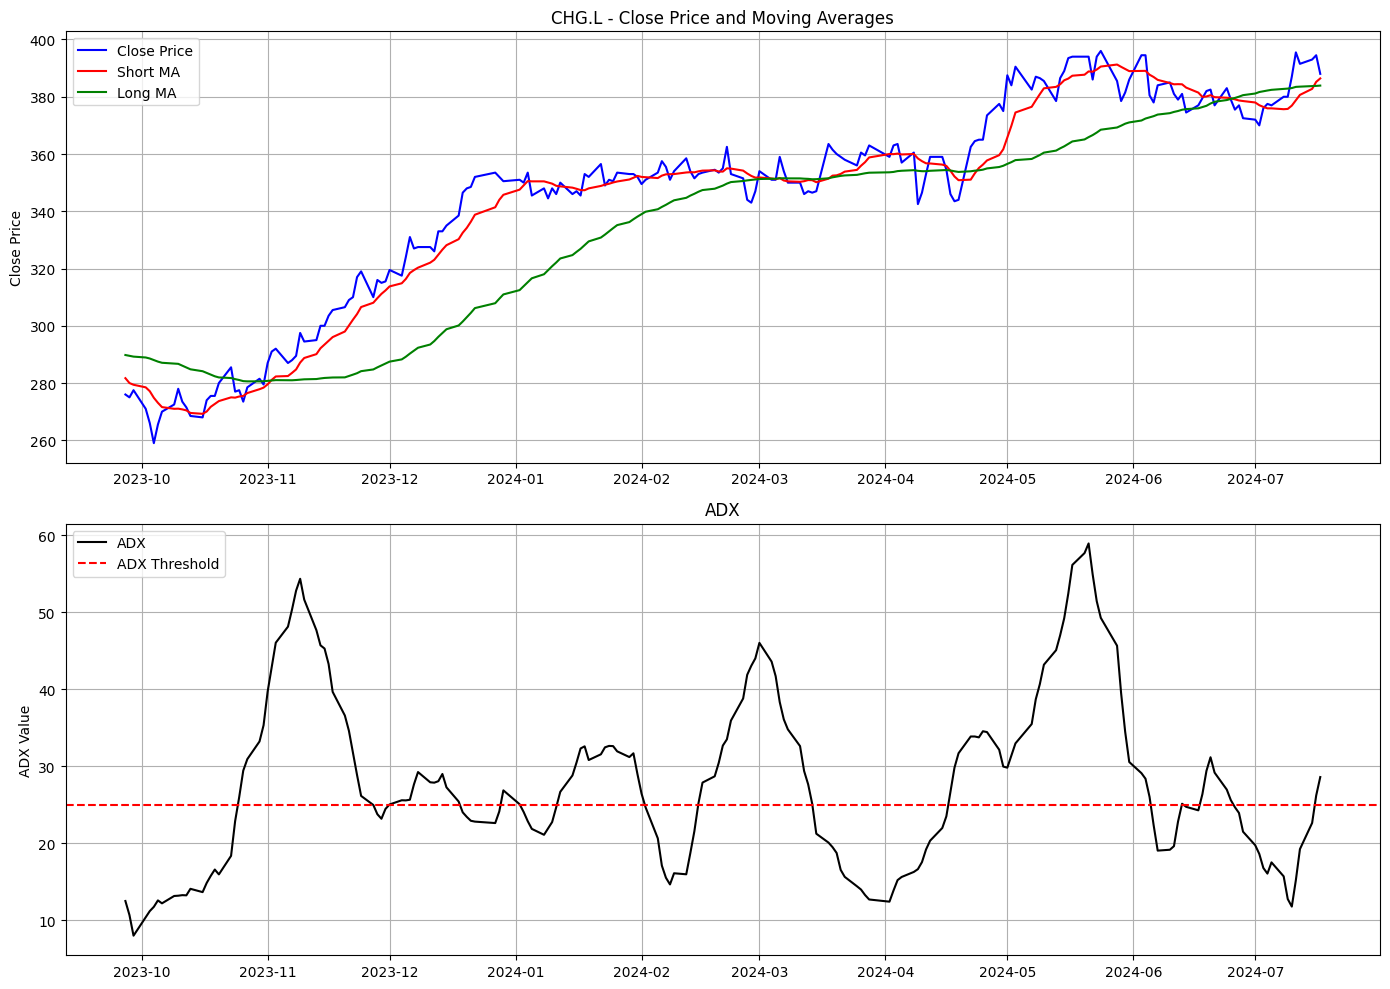

Ticker:                   CHG.L
Company:                  CHEMRING GROUP PLC ORD 1P
Sector:                   Industrials
Industry:                 Aerospace & Defense
Market Cap:               £1,042,014,208
Shares Outstanding:       271,004,992
52-Week High:             412.144
52-Week Low:              258.0
PE Ratio (TTM):           34.954544
EPS (TTM):                0.11
Dividend Yield:           0.0187
Payout Ratio:             0.633
Revenue (TTM):            £489,700,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £31,100,000
Total Debt:               £79,900,000
Operating Cash Flow (TTM): £68,000,000
Free Cash Flow (TTM):     £18,637,500

Description:              Chemring Group PLC provides countermeasures, sensors, information, and energetic products in the United States, the United Kingdom, Europe, the Asia pacific, and internationally. The company offers sensors and information products, such as point chemical detector, sensor, JSLSCAD, and I-SCAD; miniature ra

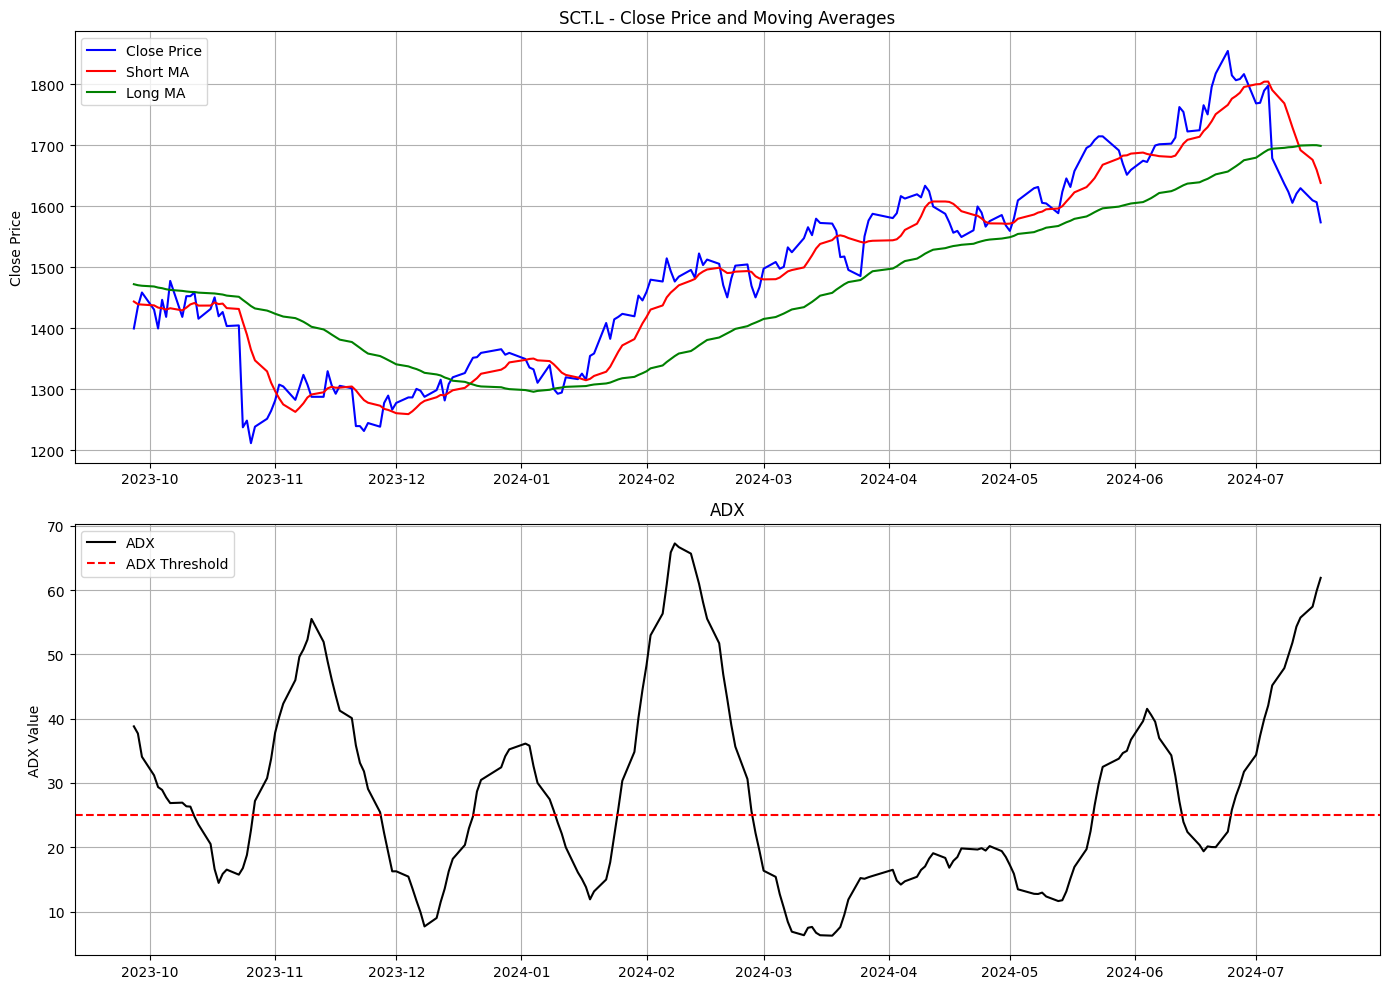

Ticker:                   SCT.L
Company:                  SOFTCAT PLC
Sector:                   Technology
Industry:                 Information Technology Services
Market Cap:               £3,152,149,504
Shares Outstanding:       199,756,000
52-Week High:             1855.0
52-Week Low:              1150.0
PE Ratio (TTM):           27.68421
EPS (TTM):                0.57
Dividend Yield:           0.0161
Payout Ratio:             0.4425
Revenue (TTM):            £940,046,976
Gross Profit (TTM):       N/A
Net Income (TTM):         £113,233,000
Total Debt:               £8,776,000
Operating Cash Flow (TTM): £94,882,000
Free Cash Flow (TTM):     £67,263,376

Description:              Softcat plc operates as a value-added IT reseller and IT infrastructure solutions provider in the United Kingdom. The company advices, procures, designs, implements, and manages technology, such as software licensing, workplace technology, networking, security, and cloud and datacenter for businesses and pub

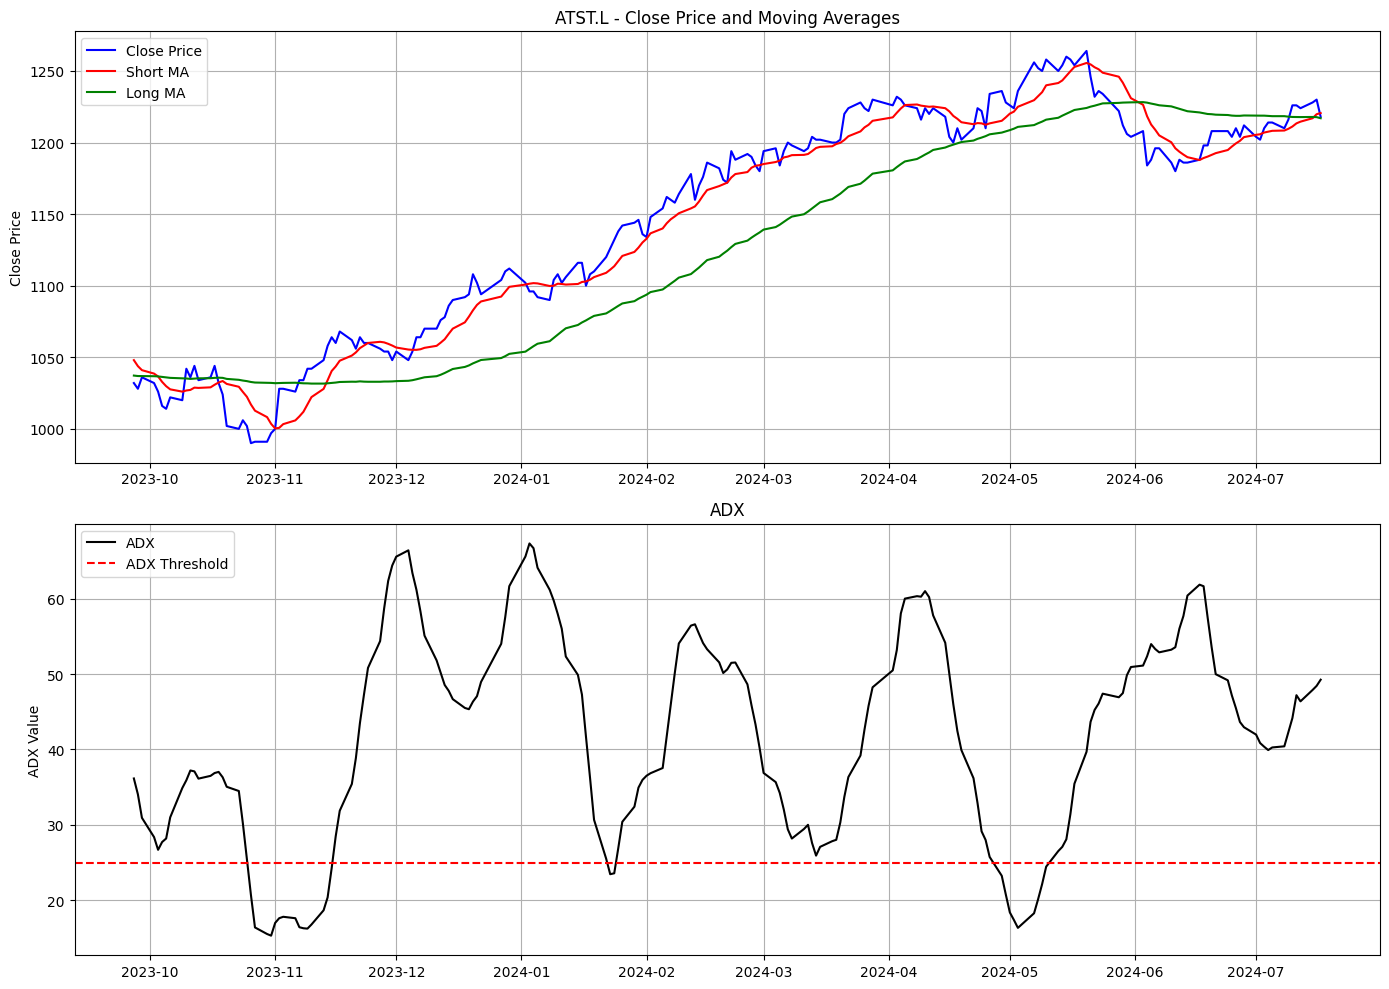

Ticker:                   ATST.L
Company:                  ALLIANCE TRUST PLC ORD 2.5P
Sector:                   N/A
Industry:                 N/A
Market Cap:               £3,436,100,096
Shares Outstanding:       N/A
52-Week High:             1287.17
52-Week Low:              980.0
PE Ratio (TTM):           5.8557696
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


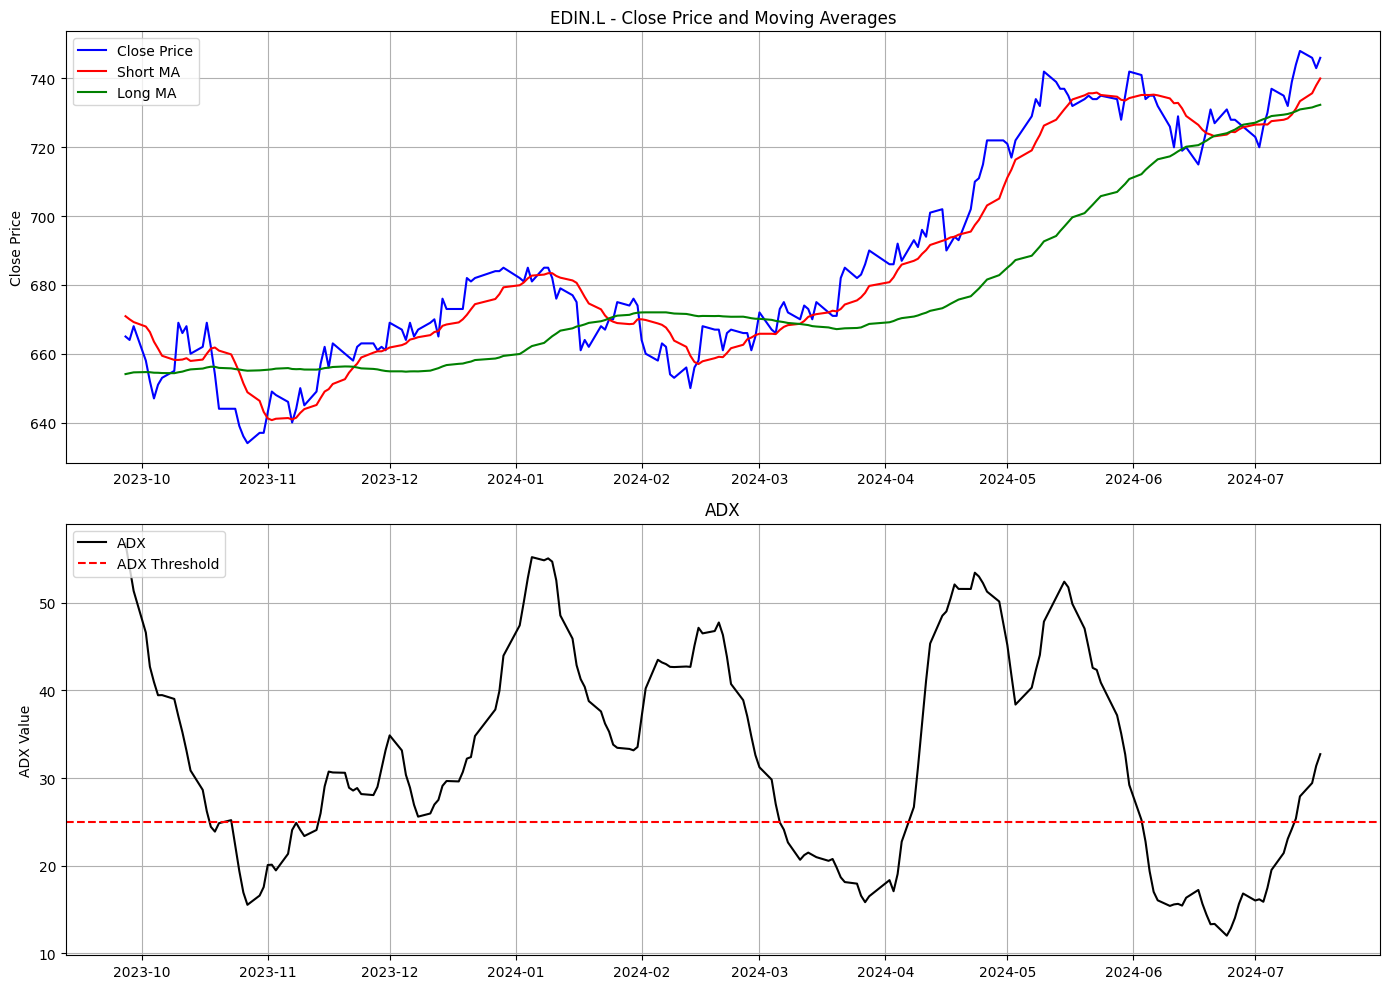

Ticker:                   EDIN.L
Company:                  EDINBURGH INVESTMENT TRUST PLC 
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,122,840,064
Shares Outstanding:       N/A
52-Week High:             761.23
52-Week Low:              629.06
PE Ratio (TTM):           9.036145
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


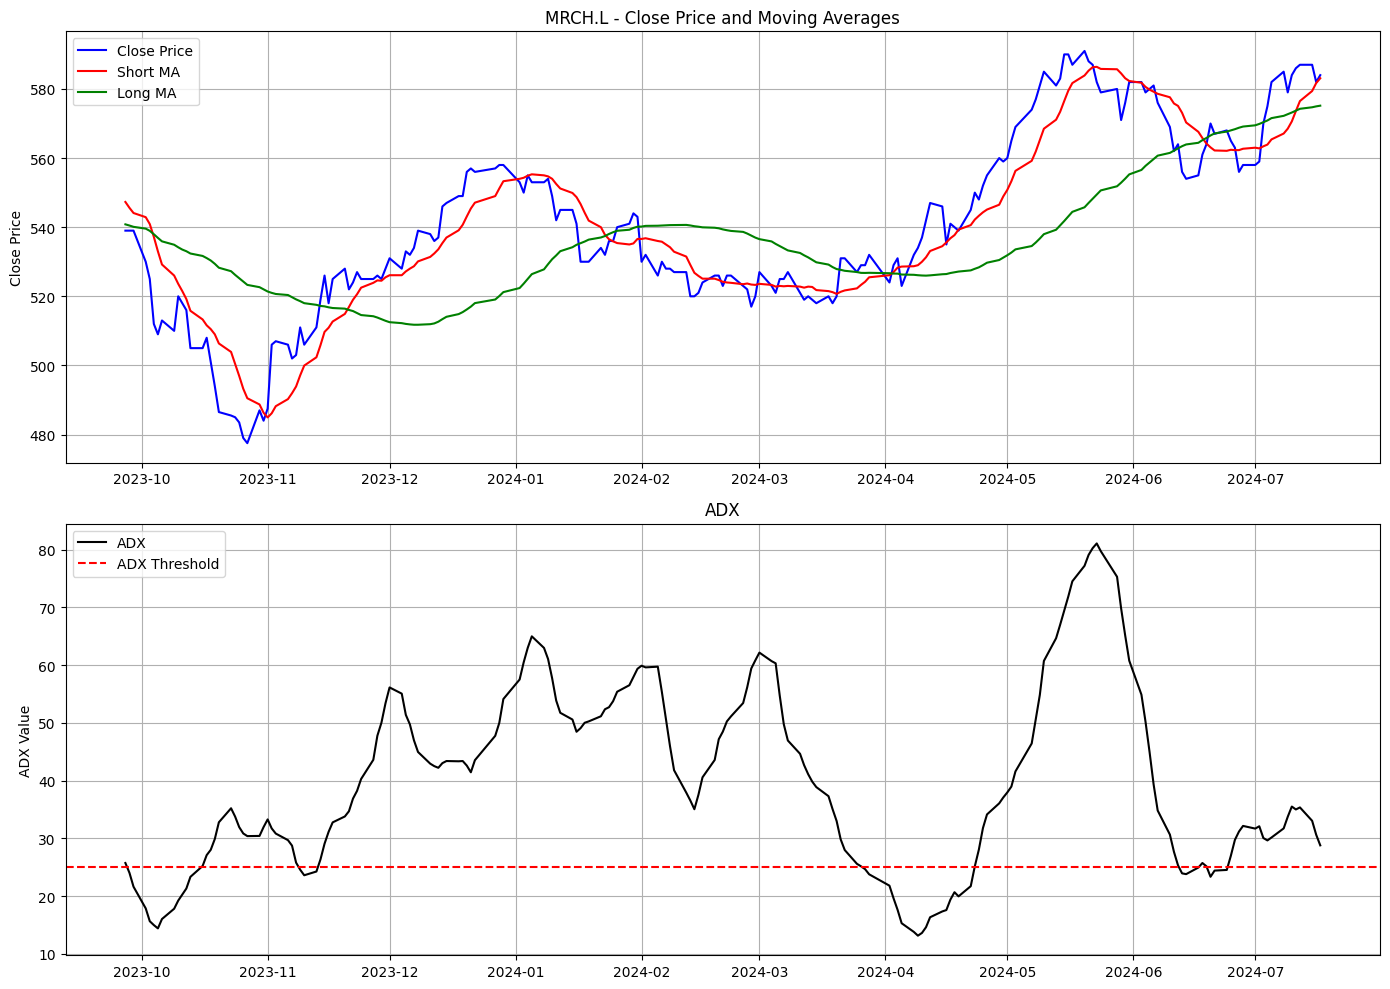

Ticker:                   MRCH.L
Company:                  MERCHANTS TRUST PLC ORD 25P
Sector:                   N/A
Industry:                 N/A
Market Cap:               £868,887,744
Shares Outstanding:       N/A
52-Week High:             593.0
52-Week Low:              476.0
PE Ratio (TTM):           N/A
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


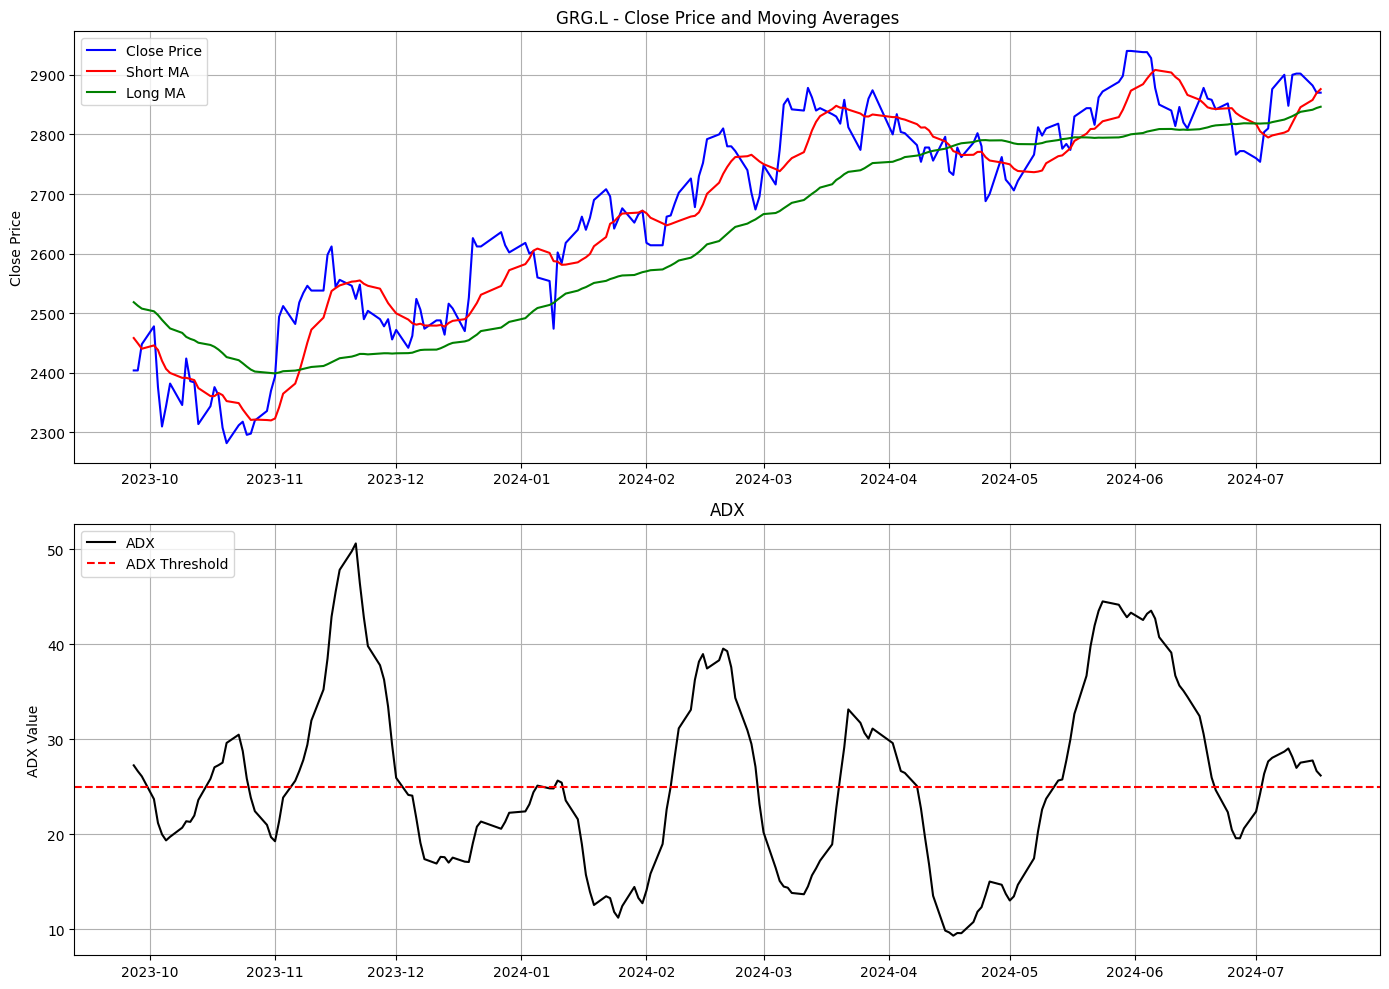

Ticker:                   GRG.L
Company:                  GREGGS PLC ORD 2P
Sector:                   Consumer Cyclical
Industry:                 Restaurants
Market Cap:               £2,880,941,312
Shares Outstanding:       101,480,000
52-Week High:             3006.0
52-Week Low:              2244.0
PE Ratio (TTM):           20.423923
EPS (TTM):                1.39
Dividend Yield:           0.0216
Payout Ratio:             0.431
Revenue (TTM):            £1,809,600,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £142,500,000
Total Debt:               £319,600,000
Operating Cash Flow (TTM): £310,800,000
Free Cash Flow (TTM):     £48,500,000

Description:              Greggs plc operates as a food-on-the-go retailer in the United Kingdom. It offers a range of fresh bakery products, sandwiches, and drinks. The company sells products to franchise and wholesale partners for sale in their own outlets. It is also involved in the property holding, non-trading, and trustee busines

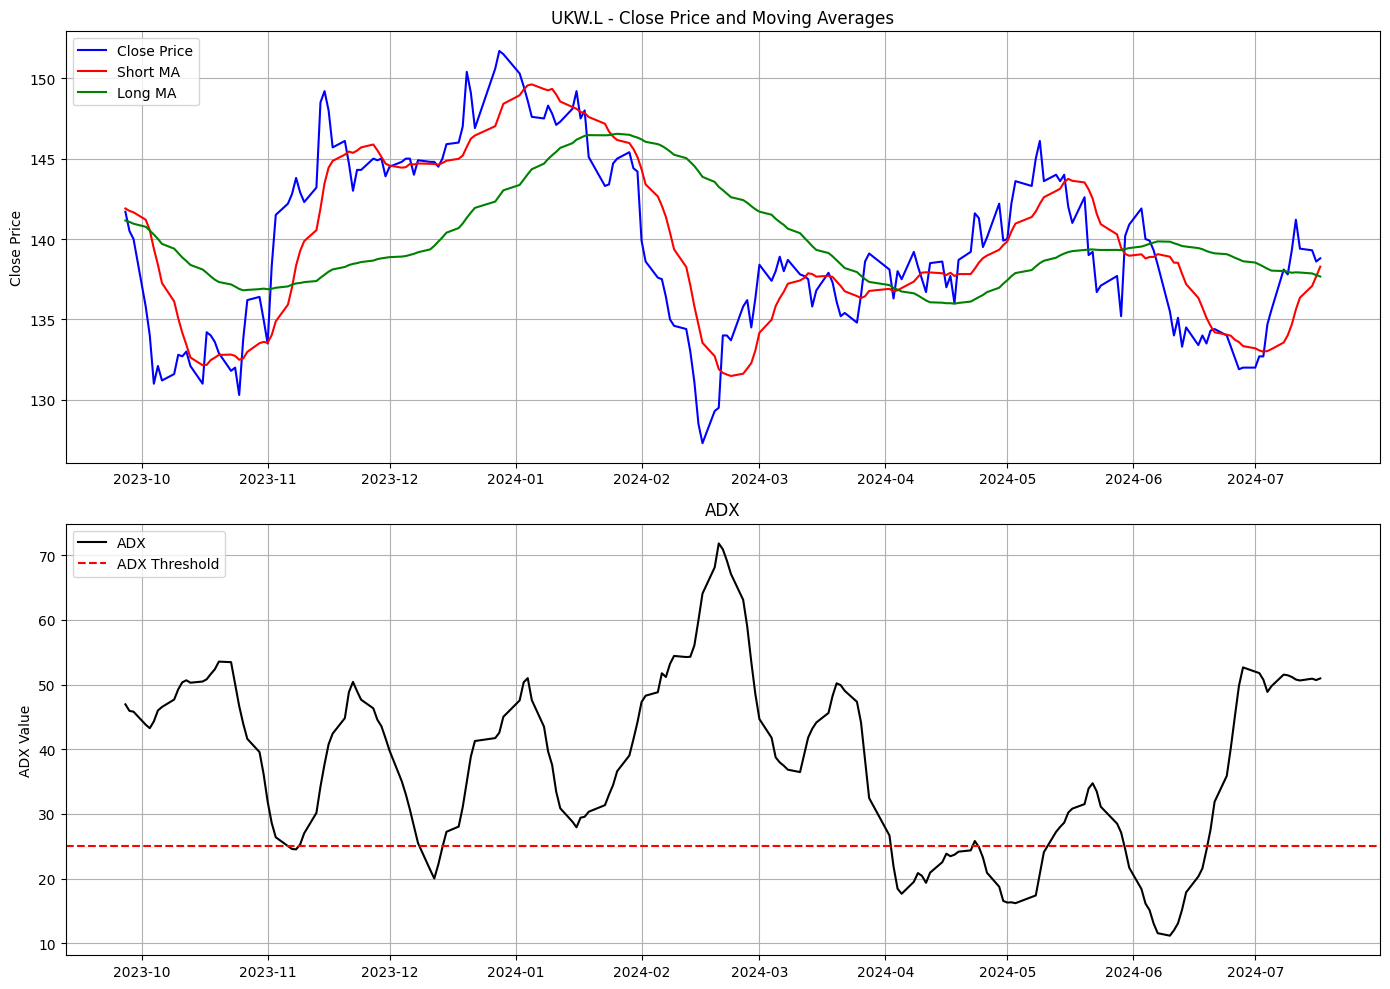

Ticker:                   UKW.L
Company:                  GREENCOAT UK WIND PLC ORD 1P
Sector:                   N/A
Industry:                 N/A
Market Cap:               £3,207,156,480
Shares Outstanding:       N/A
52-Week High:             178.03
52-Week Low:              127.3
PE Ratio (TTM):           28.1668
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


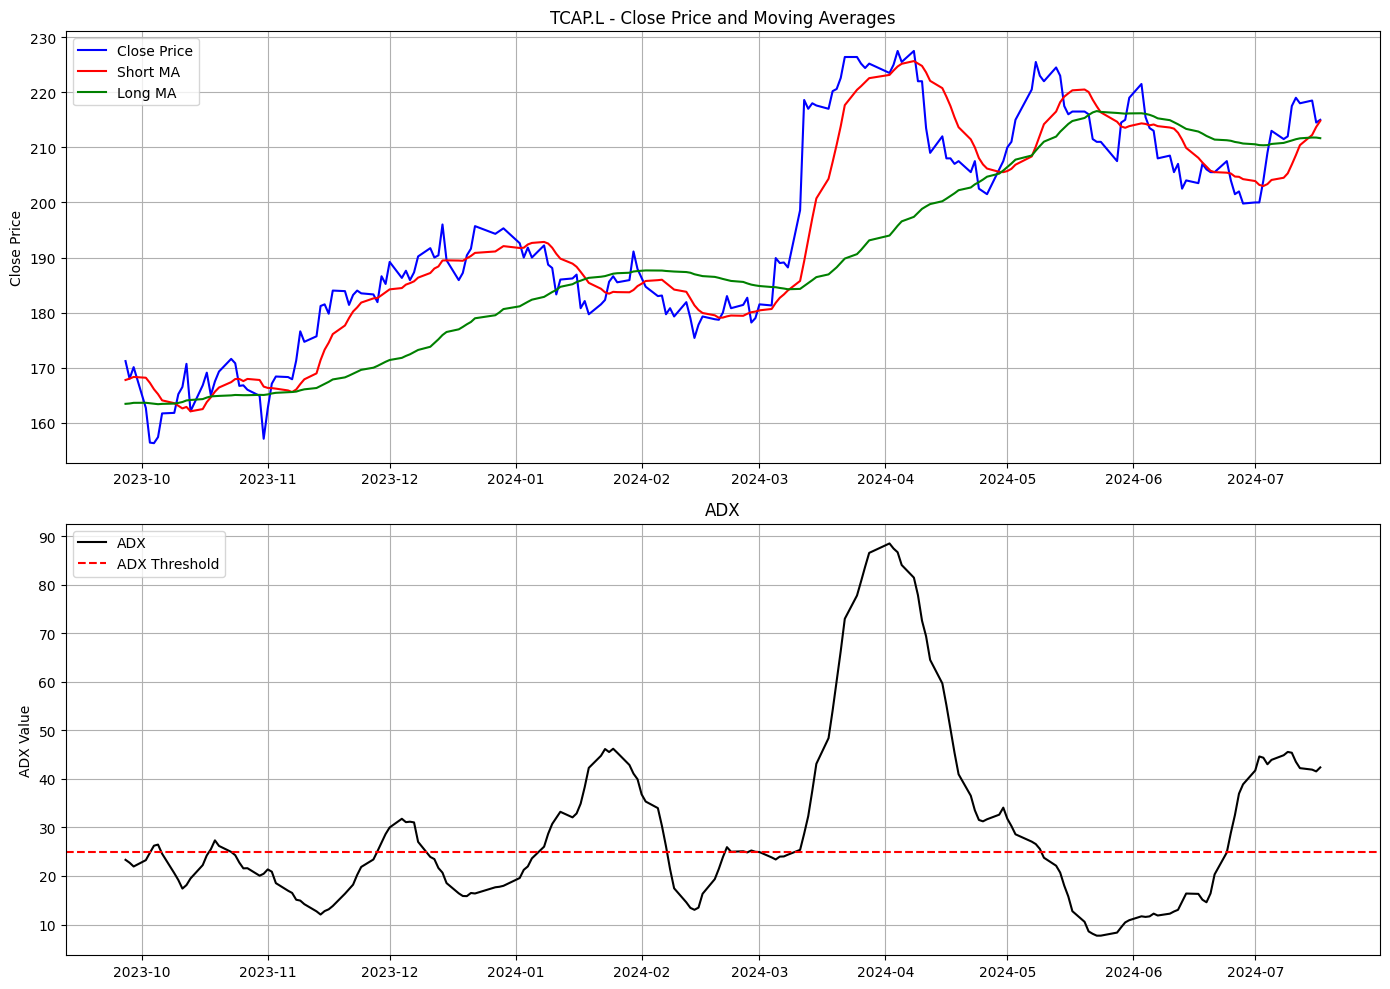

Ticker:                   TCAP.L
Company:                  TP ICAP GROUP PLC ORD 25P
Sector:                   Financial Services
Industry:                 Capital Markets
Market Cap:               £1,687,325,056
Shares Outstanding:       768,460,992
52-Week High:             230.505
52-Week Low:              151.5
PE Ratio (TTM):           24.388887
EPS (TTM):                0.09
Dividend Yield:           0.0674
Payout Ratio:             1.3656
Revenue (TTM):            £2,128,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £74,000,000
Total Debt:               £2,860,999,936
Operating Cash Flow (TTM): £270,000,000
Free Cash Flow (TTM):     N/A

Description:              TP ICAP Group PLC provides intermediary services, contextual insights, trade execution, pre-trade and settlement services, and data-led solutions in Europe, the Middle East, Africa, the Americas, and the Asia Pacific. It operates through Global Broking, Energy & Commodities, Liquidnet, and Parameta Sol

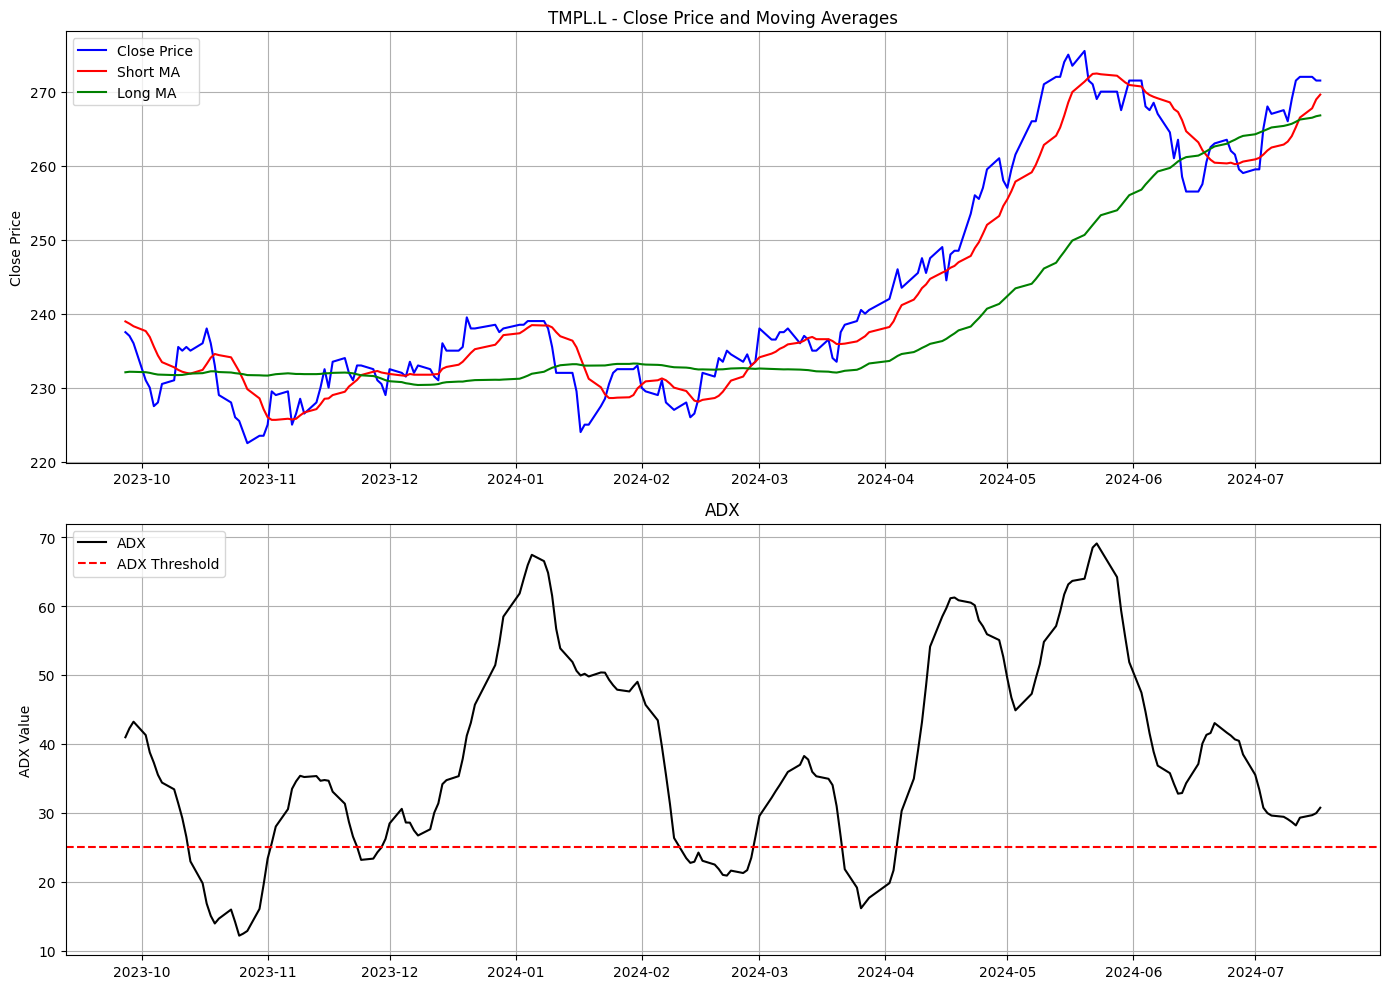

Ticker:                   TMPL.L
Company:                  TEMPLE BAR INVESTMENT TRUST PLC
Sector:                   N/A
Industry:                 N/A
Market Cap:               £790,784,192
Shares Outstanding:       N/A
52-Week High:             278.0
52-Week Low:              222.0
PE Ratio (TTM):           9.5172415
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


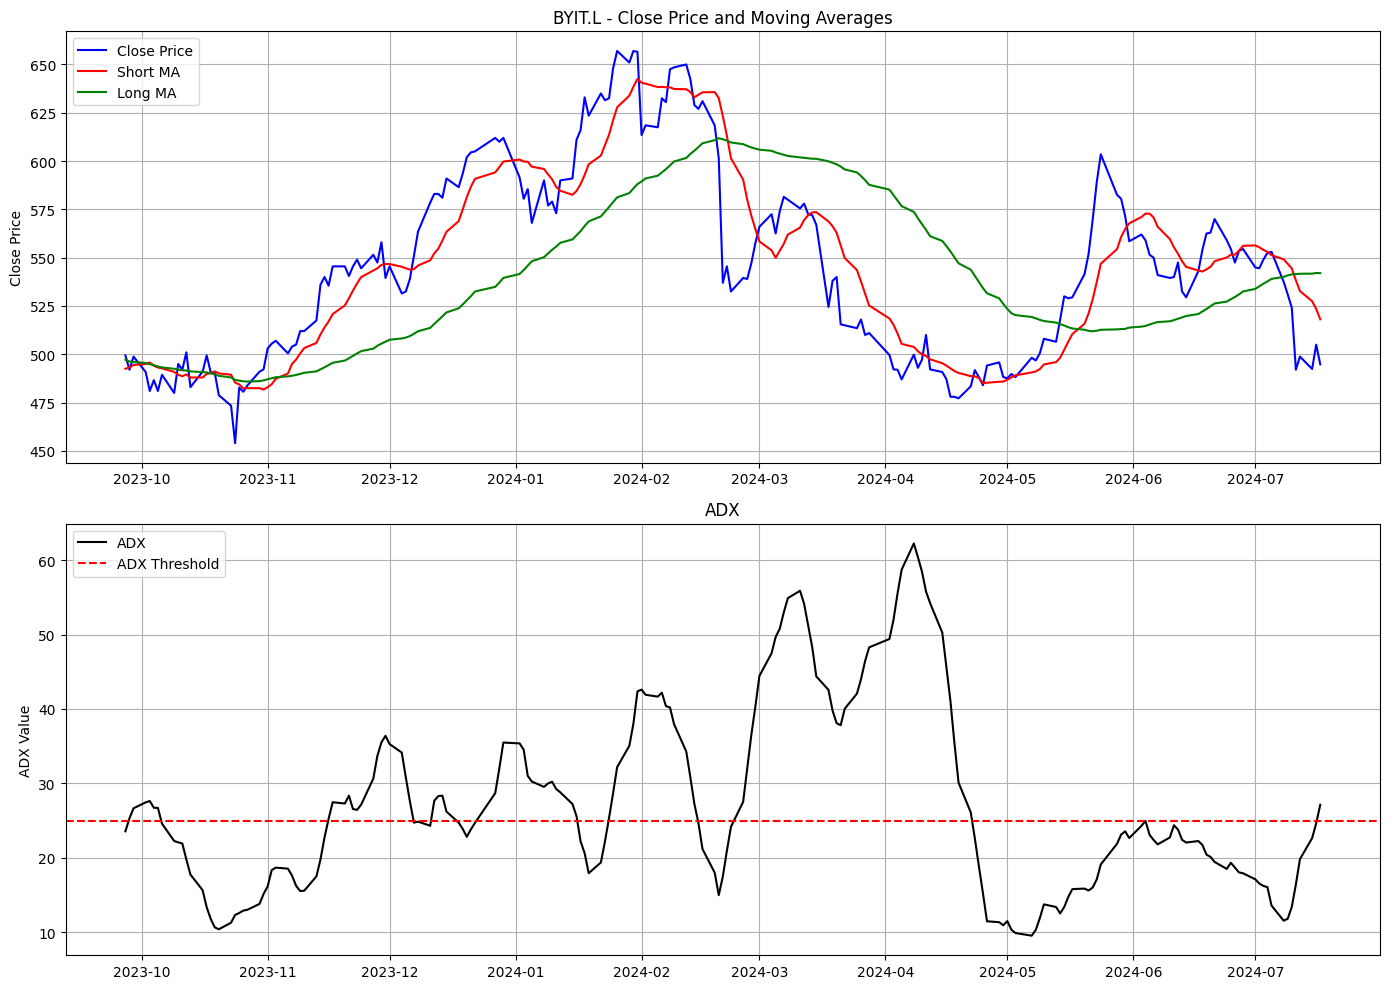

Ticker:                   BYIT.L
Company:                  BYTES TECHNOLOGY GROUP PLC ORD 
Sector:                   Technology
Industry:                 Software - Infrastructure
Market Cap:               £1,167,002,112
Shares Outstanding:       240,619,008
52-Week High:             665.0
52-Week Low:              452.6
PE Ratio (TTM):           25.526316
EPS (TTM):                0.19
Dividend Yield:           0.018
Payout Ratio:             0.4138
Revenue (TTM):            £207,020,992
Gross Profit (TTM):       N/A
Net Income (TTM):         £46,851,000
Total Debt:               £1,269,000
Operating Cash Flow (TTM): £57,005,000
Free Cash Flow (TTM):     £46,824,376

Description:              Bytes Technology Group plc offers software, IT security, hardware, and cloud services in the United Kingdom, rest of Europe, and internationally. The company sells servers, laptops, and other devices; various cloud-based and non-cloud-based licenses; and subscriptions and software assurance produ

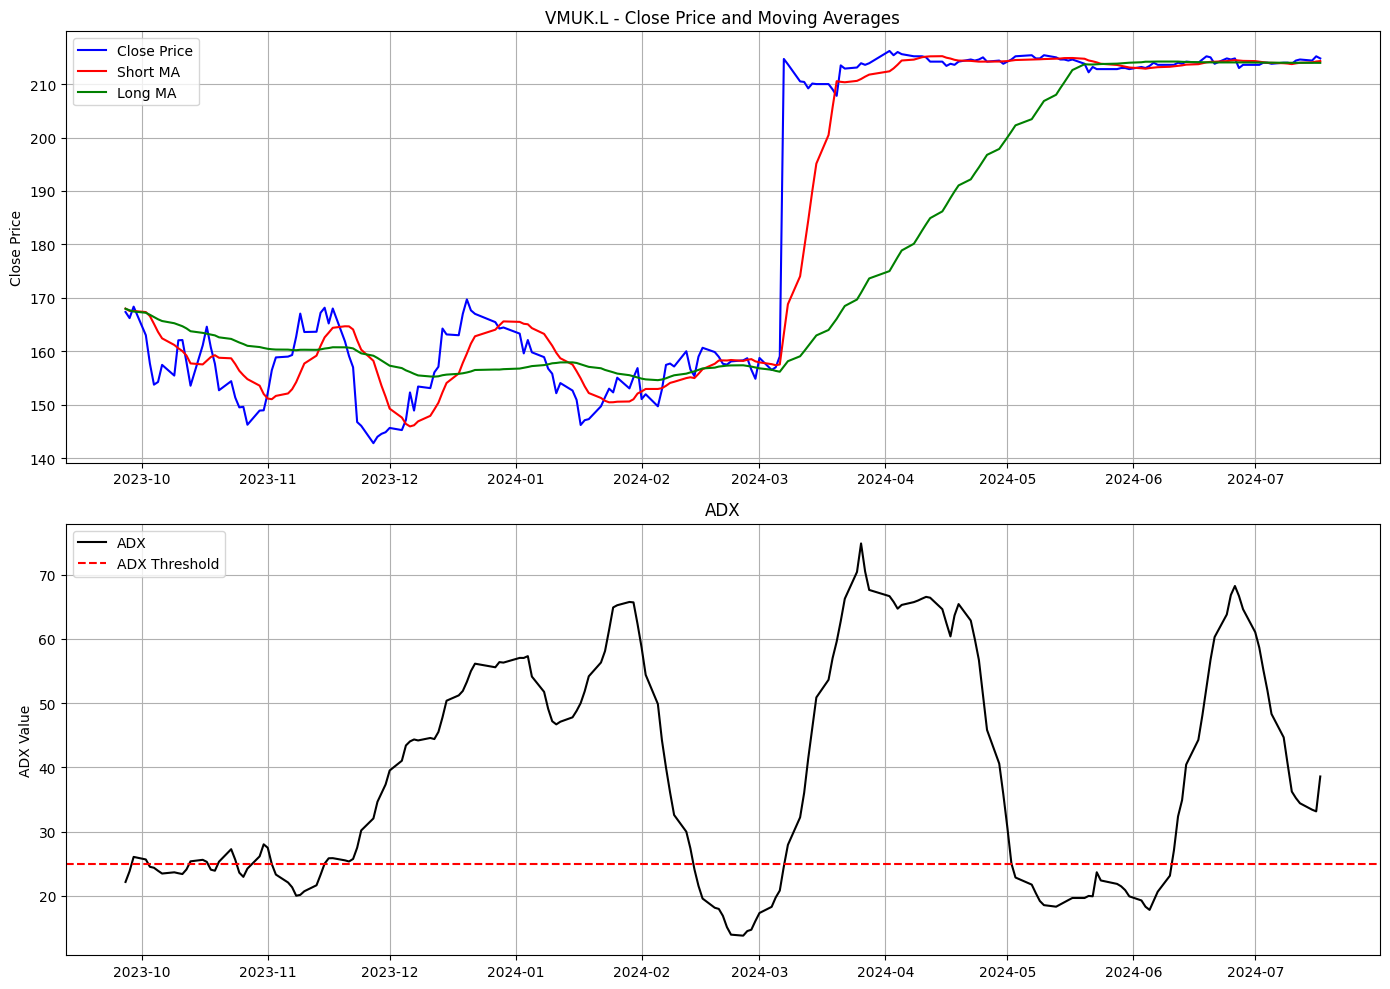

Ticker:                   VMUK.L
Company:                  VIRGIN MONEY UK PLC ORD GBP0.10
Sector:                   Financial Services
Industry:                 Banks - Regional
Market Cap:               £2,788,707,328
Shares Outstanding:       1,296,470,016
52-Week High:             219.0
52-Week Low:              140.4
PE Ratio (TTM):           9.352174
EPS (TTM):                0.23
Dividend Yield:           0.0186
Payout Ratio:             0.2333
Revenue (TTM):            £1,578,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £250,000,000
Total Debt:               £16,547,999,744
Operating Cash Flow (TTM): £1,065,000,000
Free Cash Flow (TTM):     N/A

Description:              Virgin Money UK PLC provides banking products and services for consumers, and small and medium sized businesses under the Clydesdale Bank, Yorkshire Bank, and Virgin Money brands in the United Kingdom. The company offers savings and current accounts, mortgages, credit cards, and home loans; b

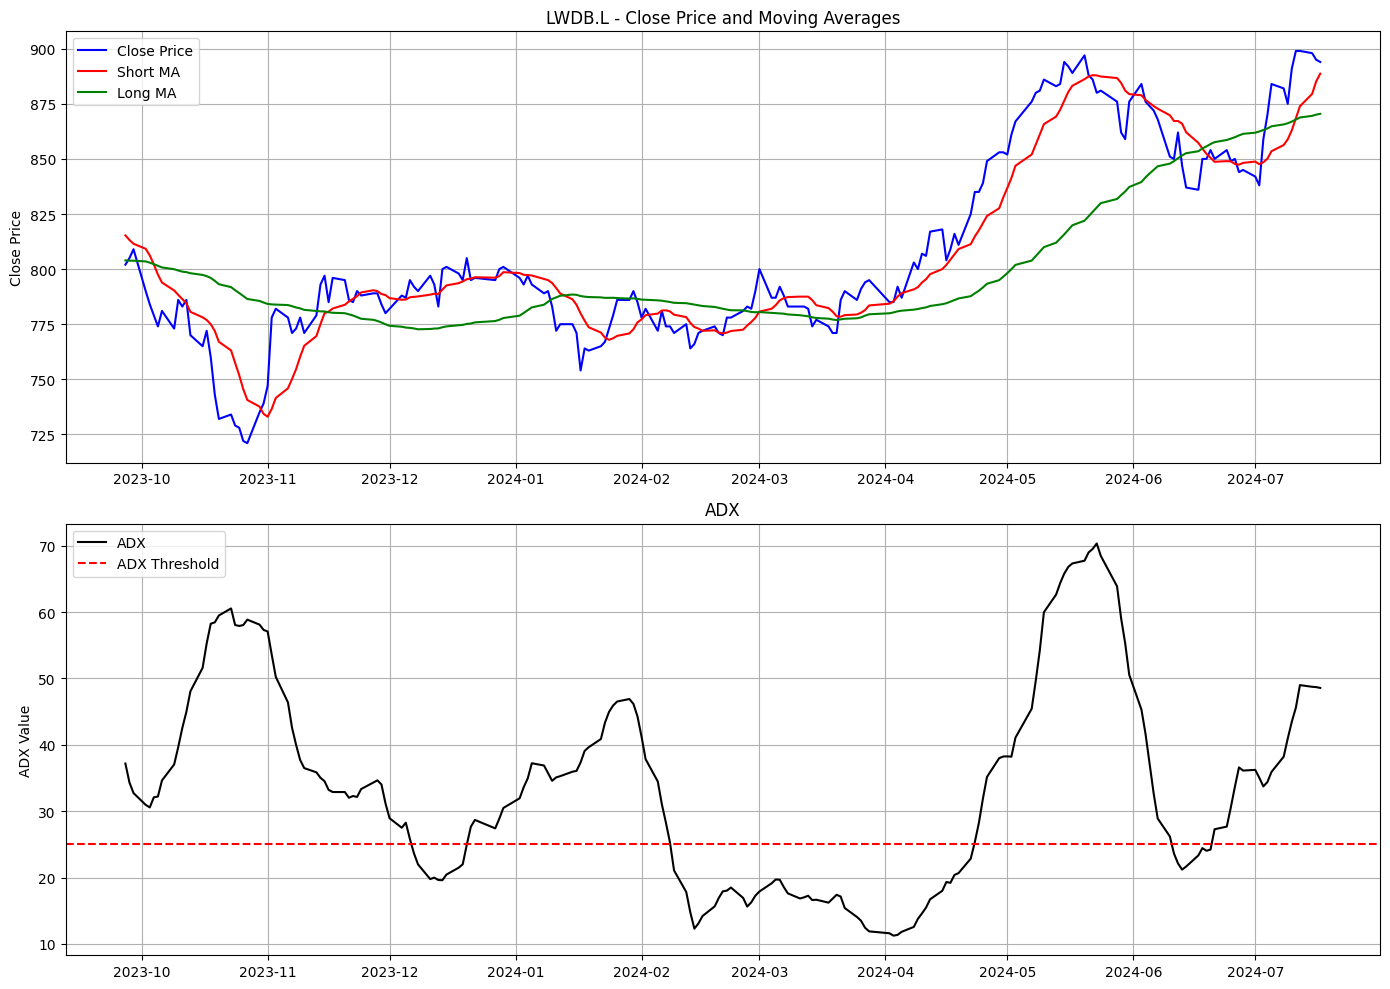

Ticker:                   LWDB.L
Company:                  LAW DEBENTURE CORPORATION PLC O
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,156,476,160
Shares Outstanding:       N/A
52-Week High:             911.0
52-Week Low:              718.04
PE Ratio (TTM):           15.266481
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


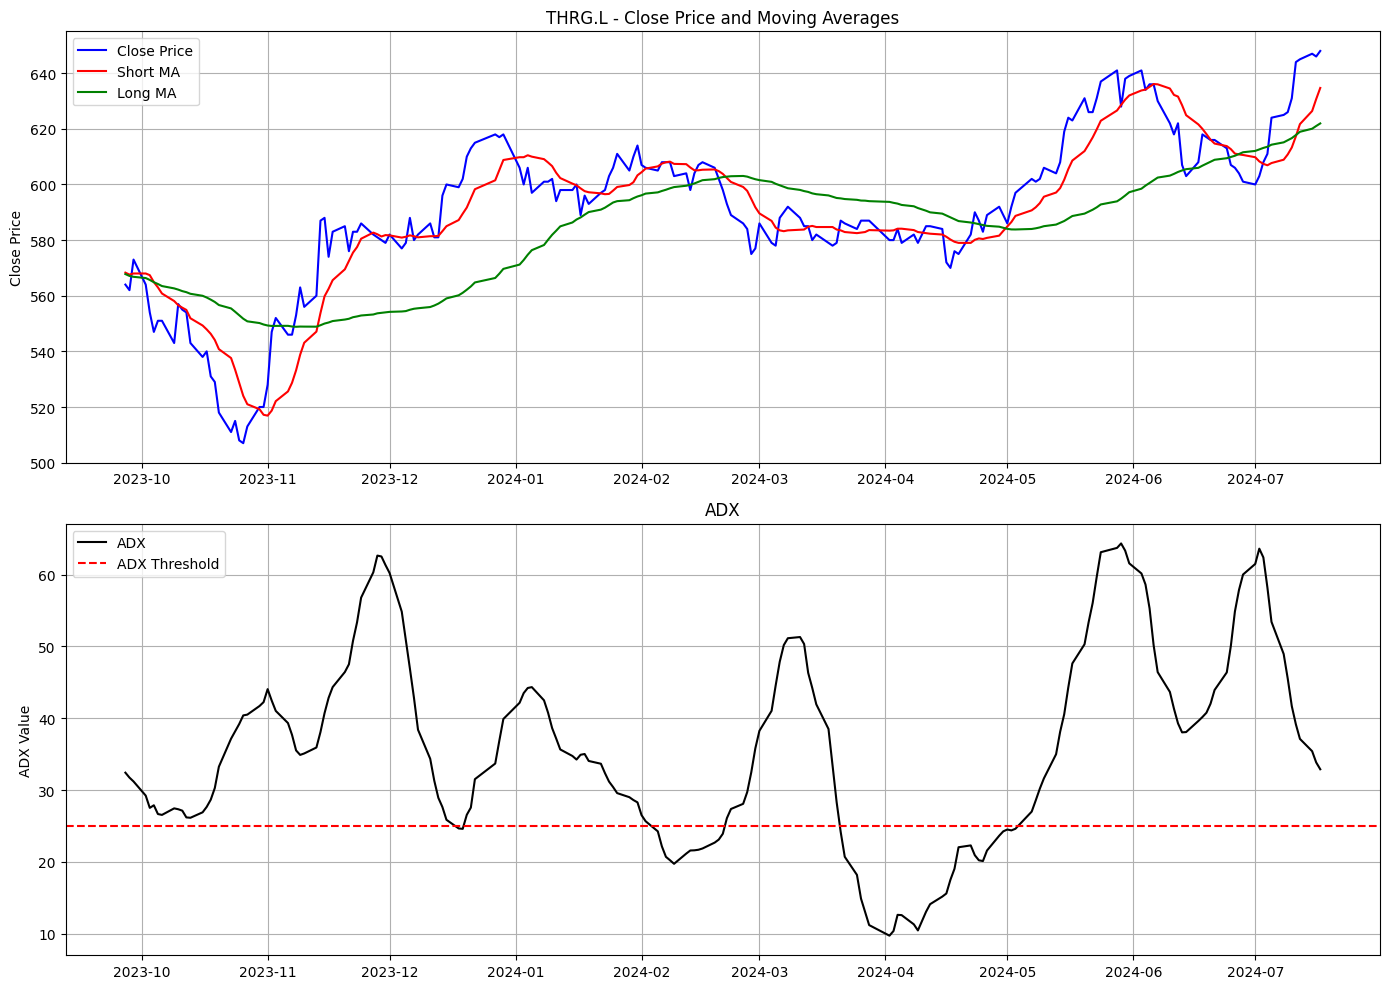

Ticker:                   THRG.L
Company:                  BLACKROCK THROGMORTON TRUST PLC
Sector:                   N/A
Industry:                 N/A
Market Cap:               £589,758,656
Shares Outstanding:       N/A
52-Week High:             663.98
52-Week Low:              503.0
PE Ratio (TTM):           N/A
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


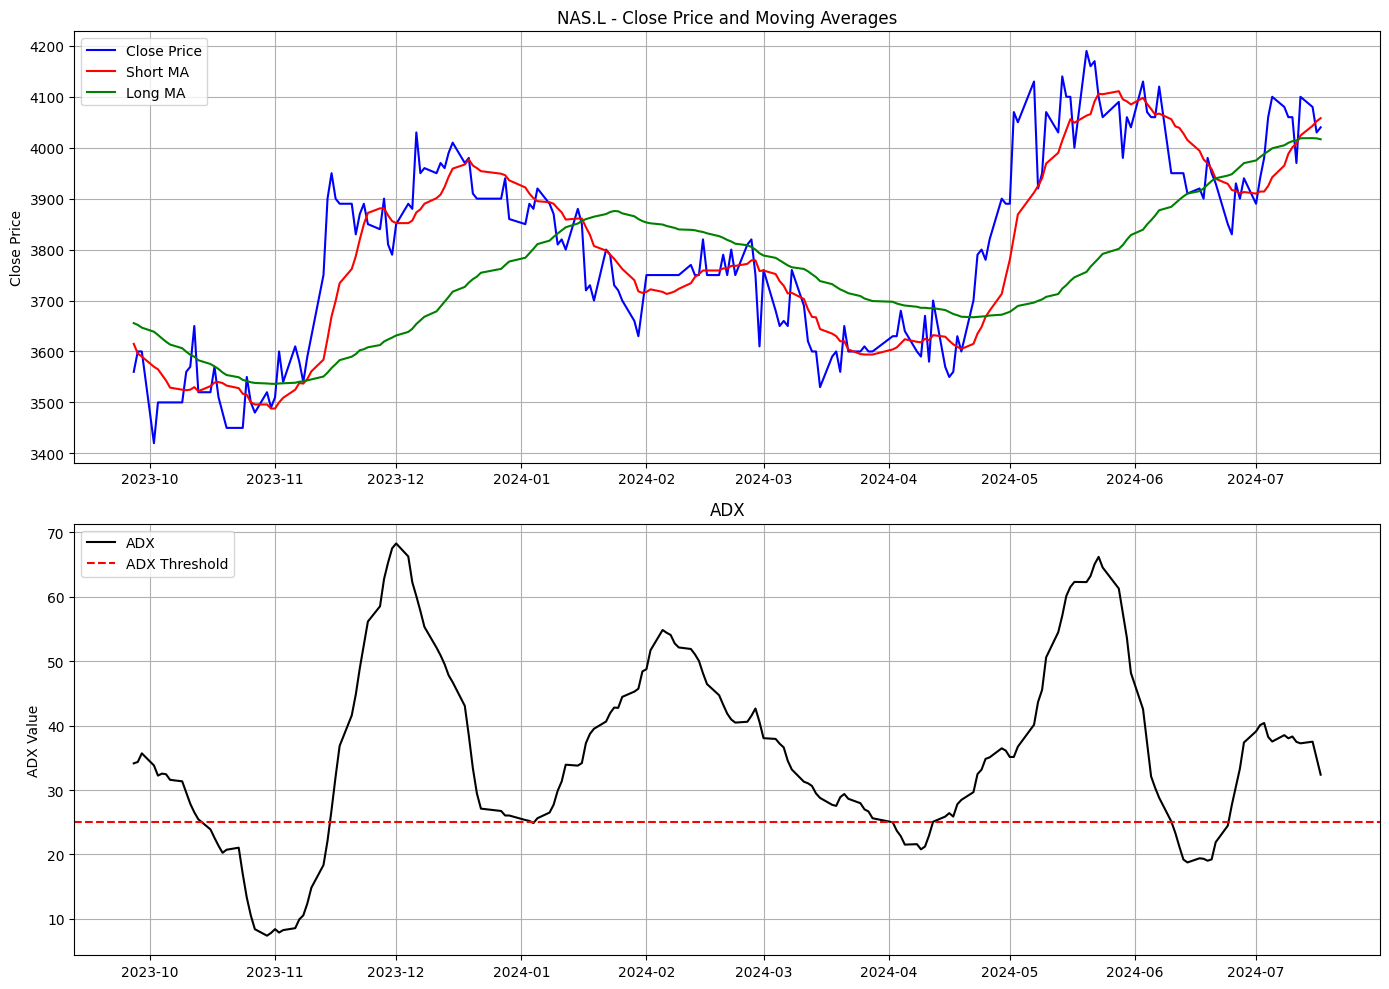

Ticker:                   NAS.L
Company:                  NORTH ATLANTIC SMALLER COMPANIE
Sector:                   N/A
Industry:                 N/A
Market Cap:               £539,740,544
Shares Outstanding:       N/A
52-Week High:             5277.972
52-Week Low:              3420.0
PE Ratio (TTM):           252.09459
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


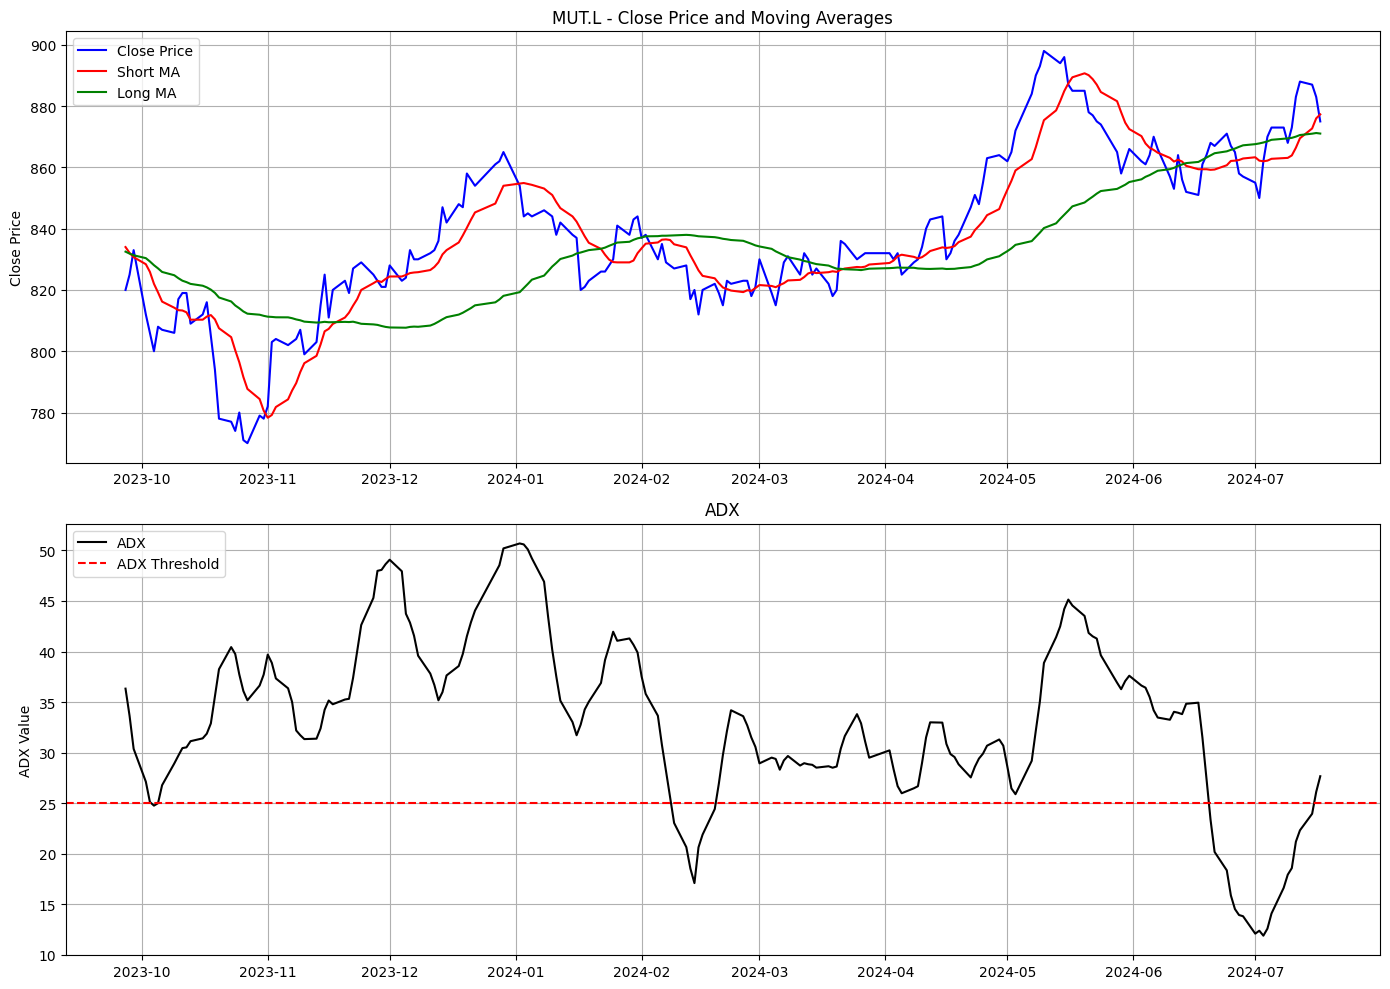

Ticker:                   MUT.L
Company:                  MURRAY INCOME TRUST PLC ORD 25P
Sector:                   N/A
Industry:                 N/A
Market Cap:               £912,765,184
Shares Outstanding:       N/A
52-Week High:             935.92
52-Week Low:              766.6
PE Ratio (TTM):           12.124999
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


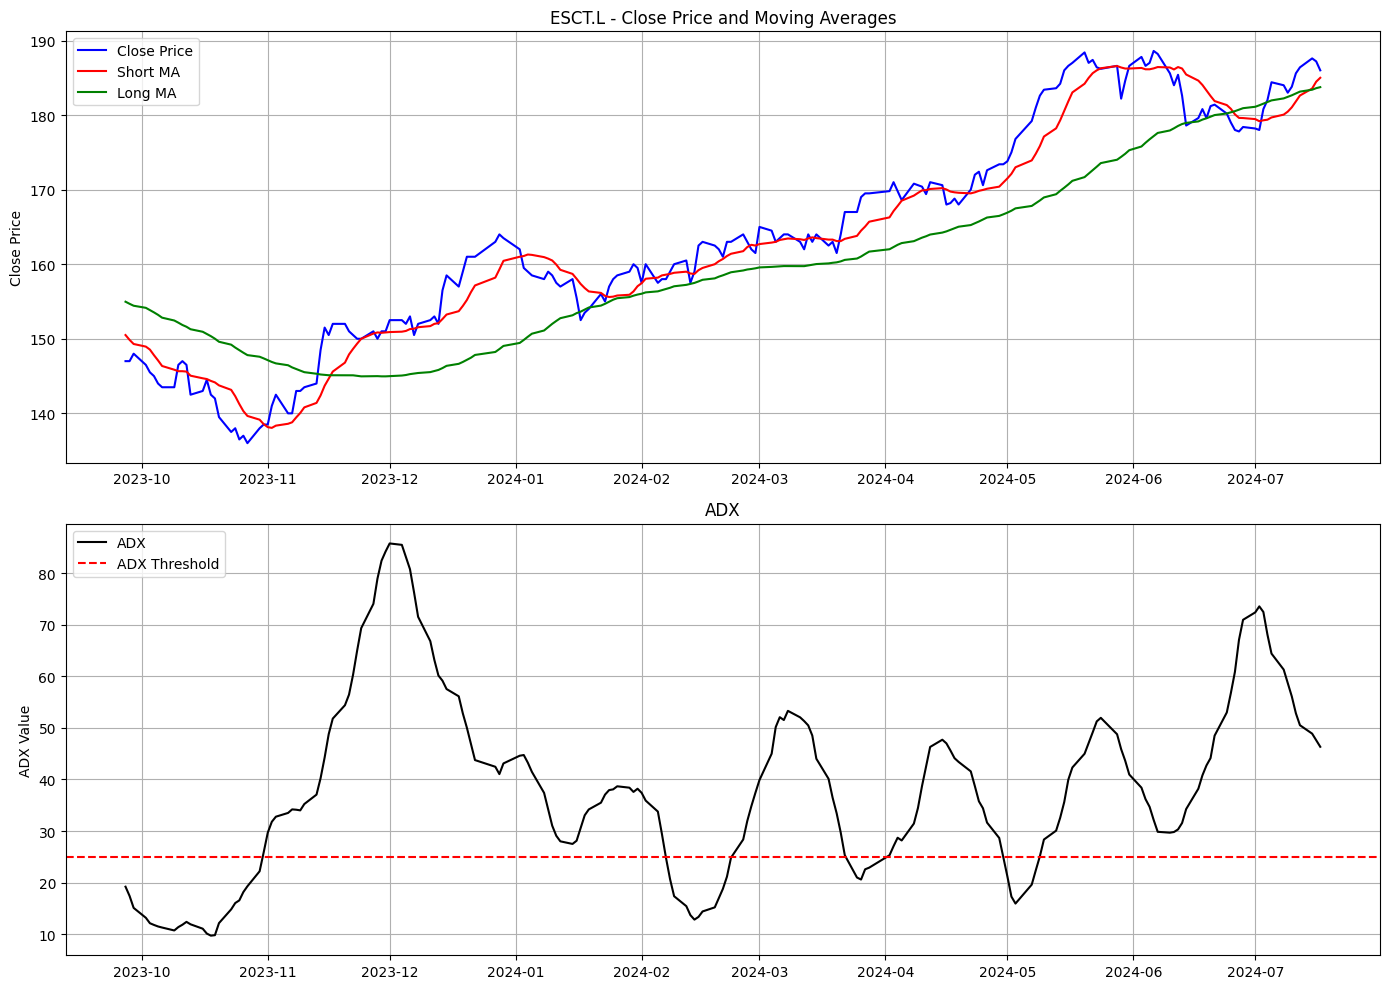

Ticker:                   ESCT.L
Company:                  THE EUROPEAN SMALLER COMPANIES 
Sector:                   N/A
Industry:                 N/A
Market Cap:               £736,571,968
Shares Outstanding:       N/A
52-Week High:             196.94
52-Week Low:              135.5
PE Ratio (TTM):           9.2699995
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


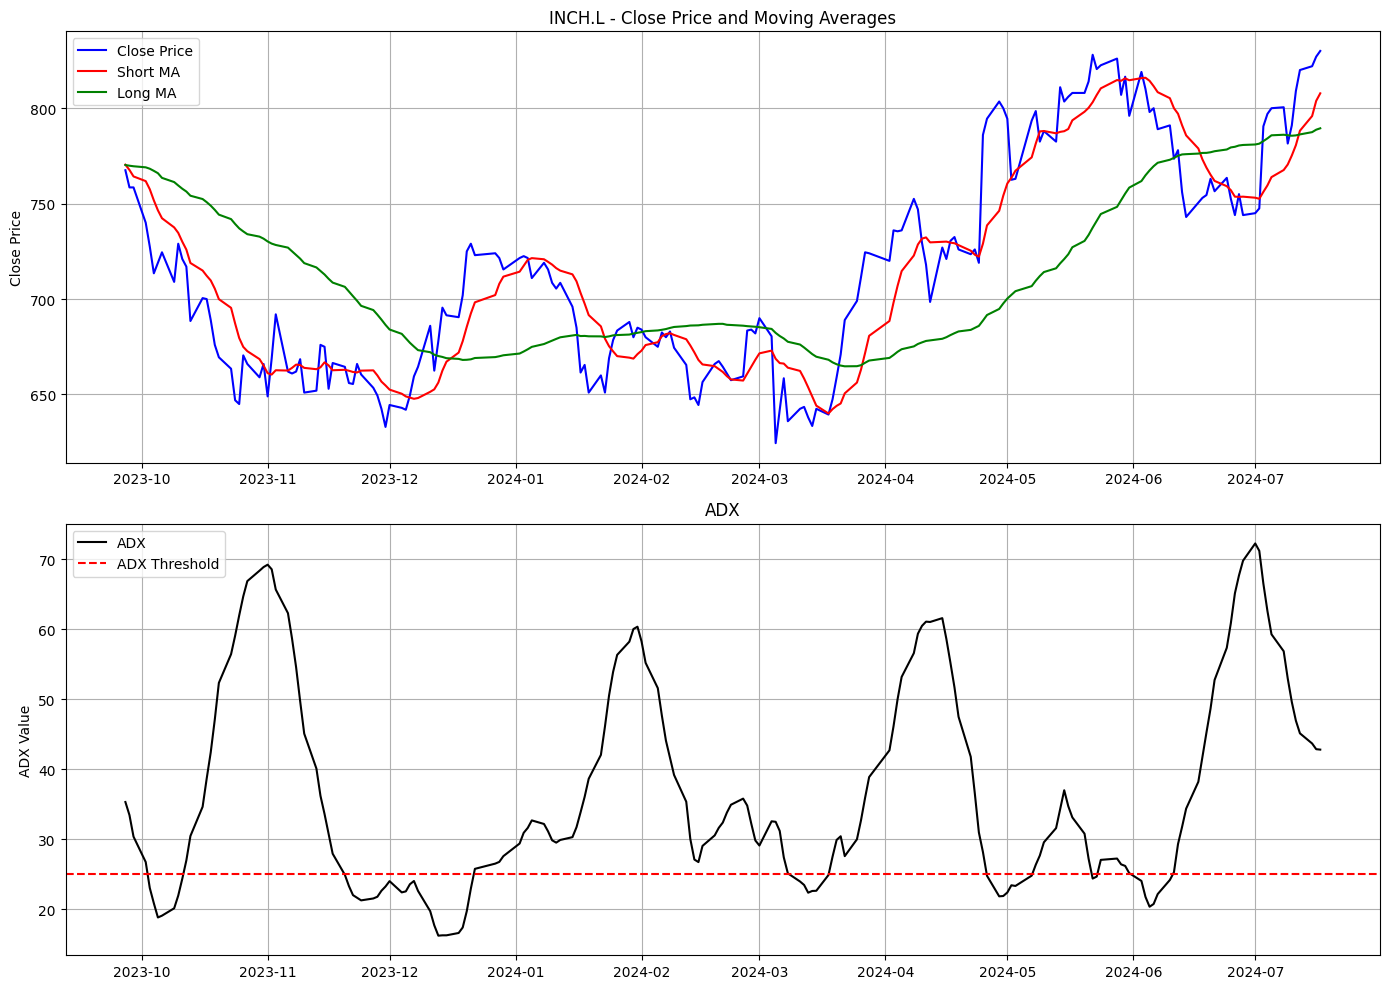

Ticker:                   INCH.L
Company:                  INCHCAPE PLC ORD 10P
Sector:                   Consumer Cyclical
Industry:                 Auto & Truck Dealerships
Market Cap:               £3,442,251,776
Shares Outstanding:       411,999,008
52-Week High:             892.5
52-Week Low:              597.5
PE Ratio (TTM):           12.853846
EPS (TTM):                0.65
Dividend Yield:           0.040900003
Payout Ratio:             0.47689998
Revenue (TTM):            £11,447,000,064
Gross Profit (TTM):       N/A
Net Income (TTM):         £270,000,000
Total Debt:               £3,607,000,064
Operating Cash Flow (TTM): £593,000,000
Free Cash Flow (TTM):     £-141,124,992

Description:              Inchcape plc operates as an automotive distributor and retailer. It engages in the distribution, sales, and marketing of new and used cars, and parts. The company also provides aftersales service and body shop repairs; and finance and insurance products and services, as well as pr

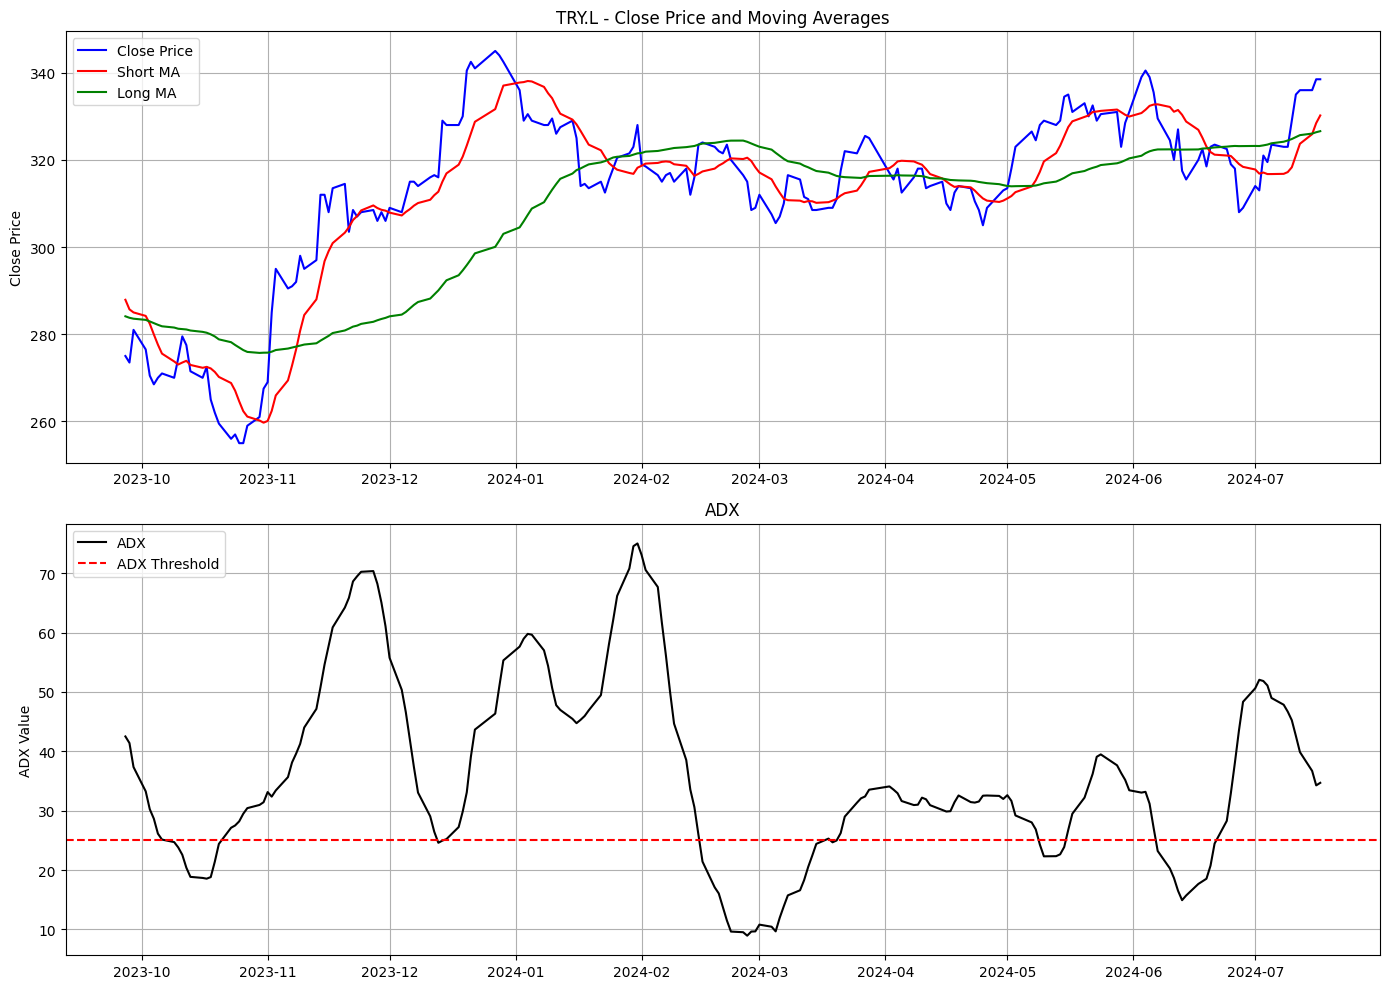

Ticker:                   TRY.L
Company:                  TR PROPERTY INVESTMENT TRUST PL
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,067,886,208
Shares Outstanding:       N/A
52-Week High:             361.33
52-Week Low:              252.95
PE Ratio (TTM):           5.427419
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


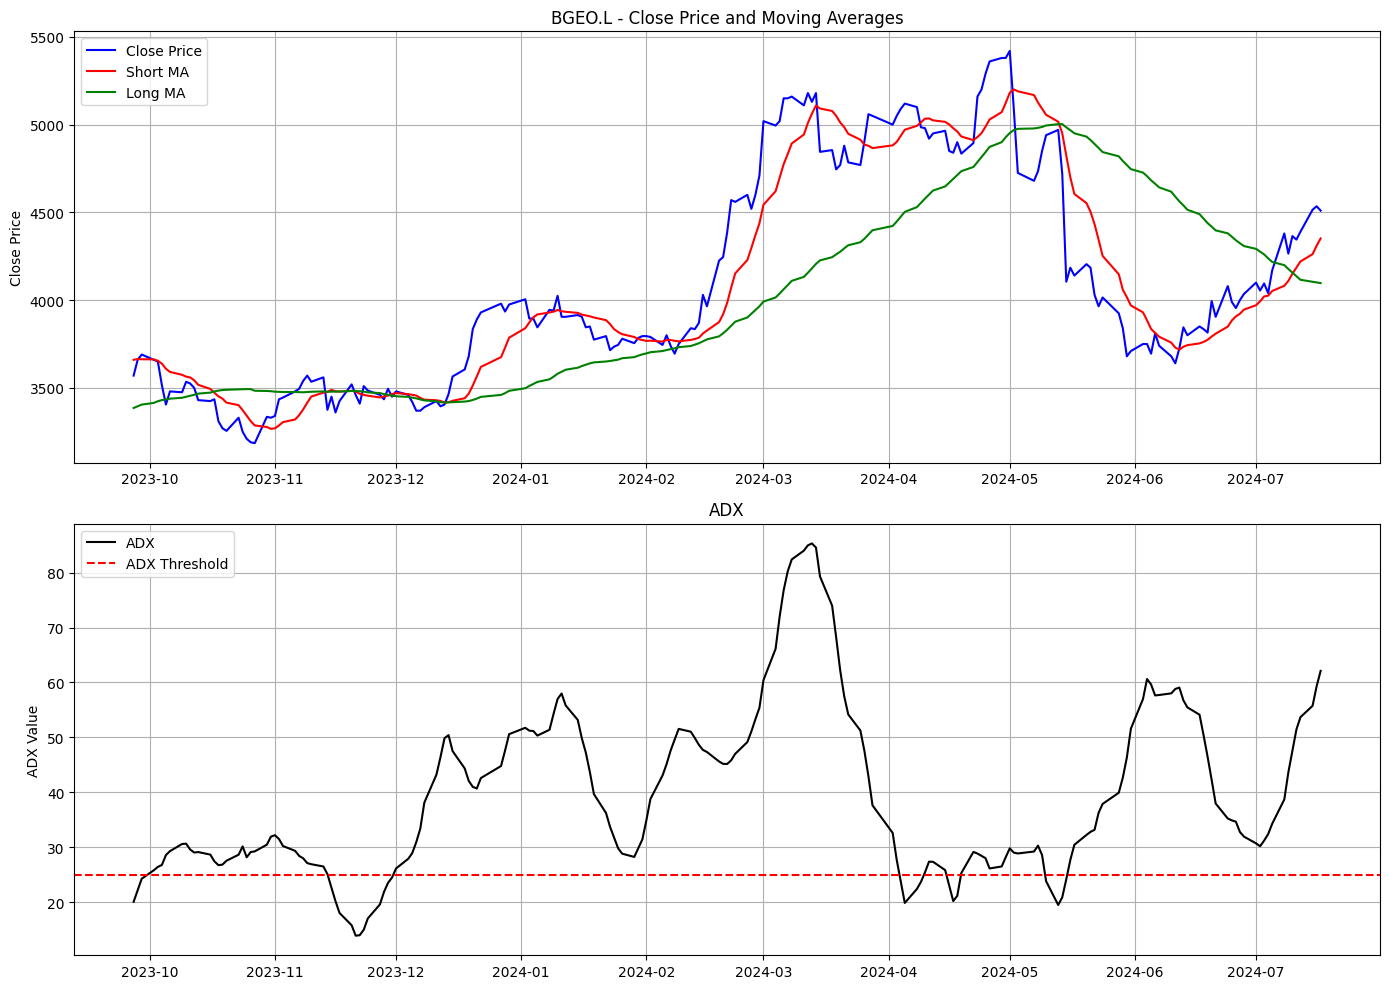

Ticker:                   BGEO.L
Company:                  BANK OF GEORGIA GROUP PLC ORD 1
Sector:                   Financial Services
Industry:                 Banks - Regional
Market Cap:               £1,983,594,880
Shares Outstanding:       44,827,000
52-Week High:             5510.0
52-Week Low:              3037.5
PE Ratio (TTM):           3.3396227
EPS (TTM):                13.25
Dividend Yield:           0.0519
Payout Ratio:             0.188
Revenue (TTM):            £2,530,534,912
Gross Profit (TTM):       N/A
Net Income (TTM):         £2,127,463,936
Total Debt:               £7,204,170,240
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              Bank of Georgia Group PLC, through its subsidiaries, provides banking and financial services with focus on the Georgian and Armenian markets. It operates through Georgian Financial Services, Armenian Financial Services, and Other Businesses segments. The Georgian Financial Services segment provides ret

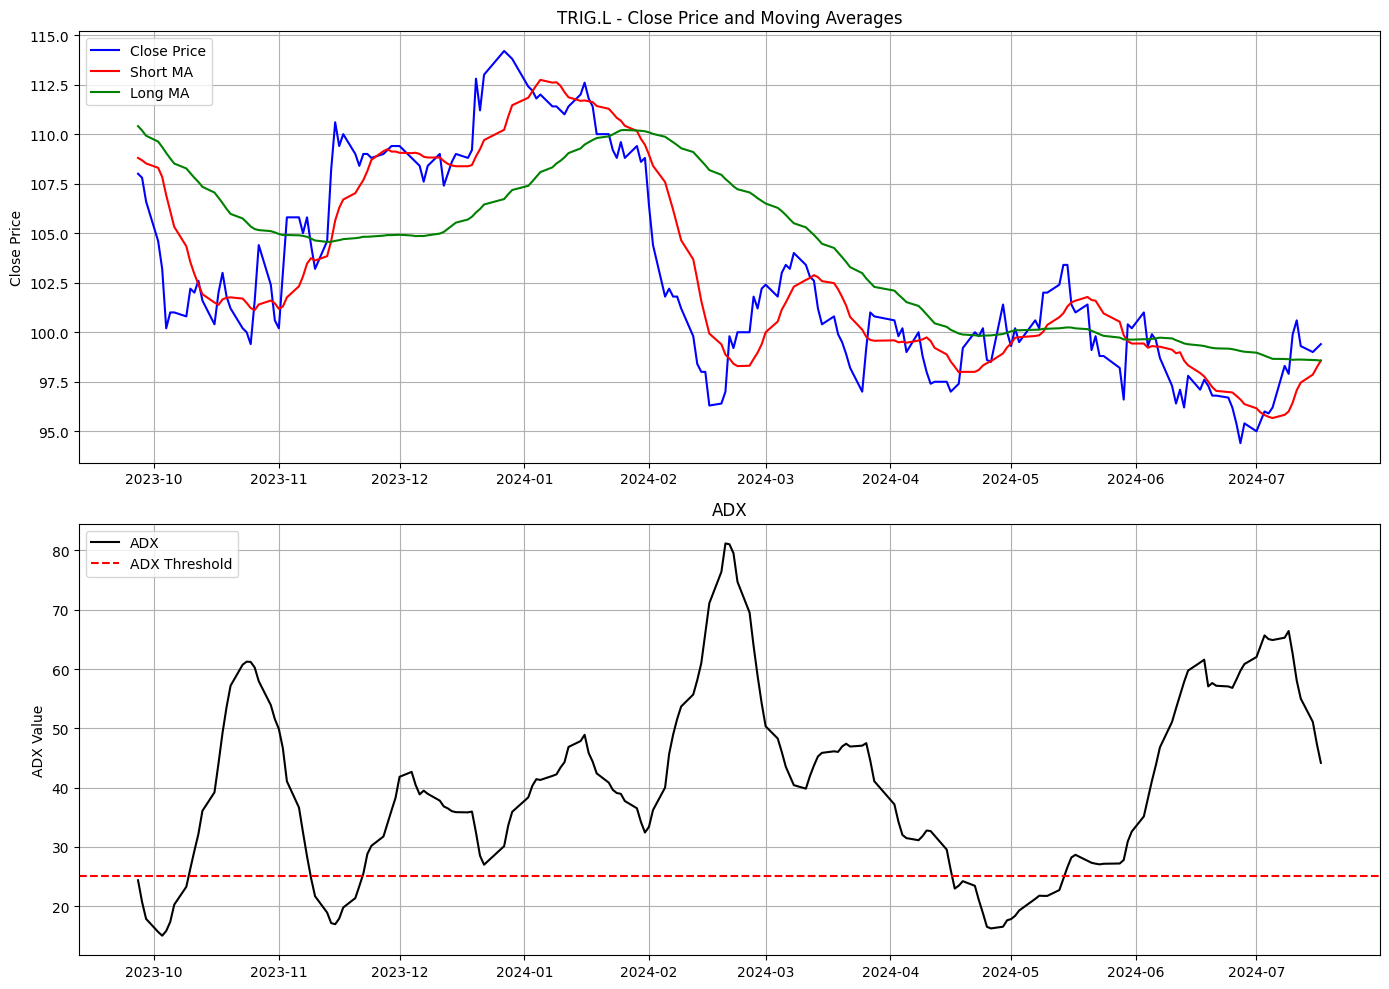

Ticker:                   TRIG.L
Company:                  THE RENEWABLES INFRASTRUCTURE G
Sector:                   N/A
Industry:                 N/A
Market Cap:               £2,500,050,688
Shares Outstanding:       N/A
52-Week High:             129.133
52-Week Low:              92.8
PE Ratio (TTM):           Infinity
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


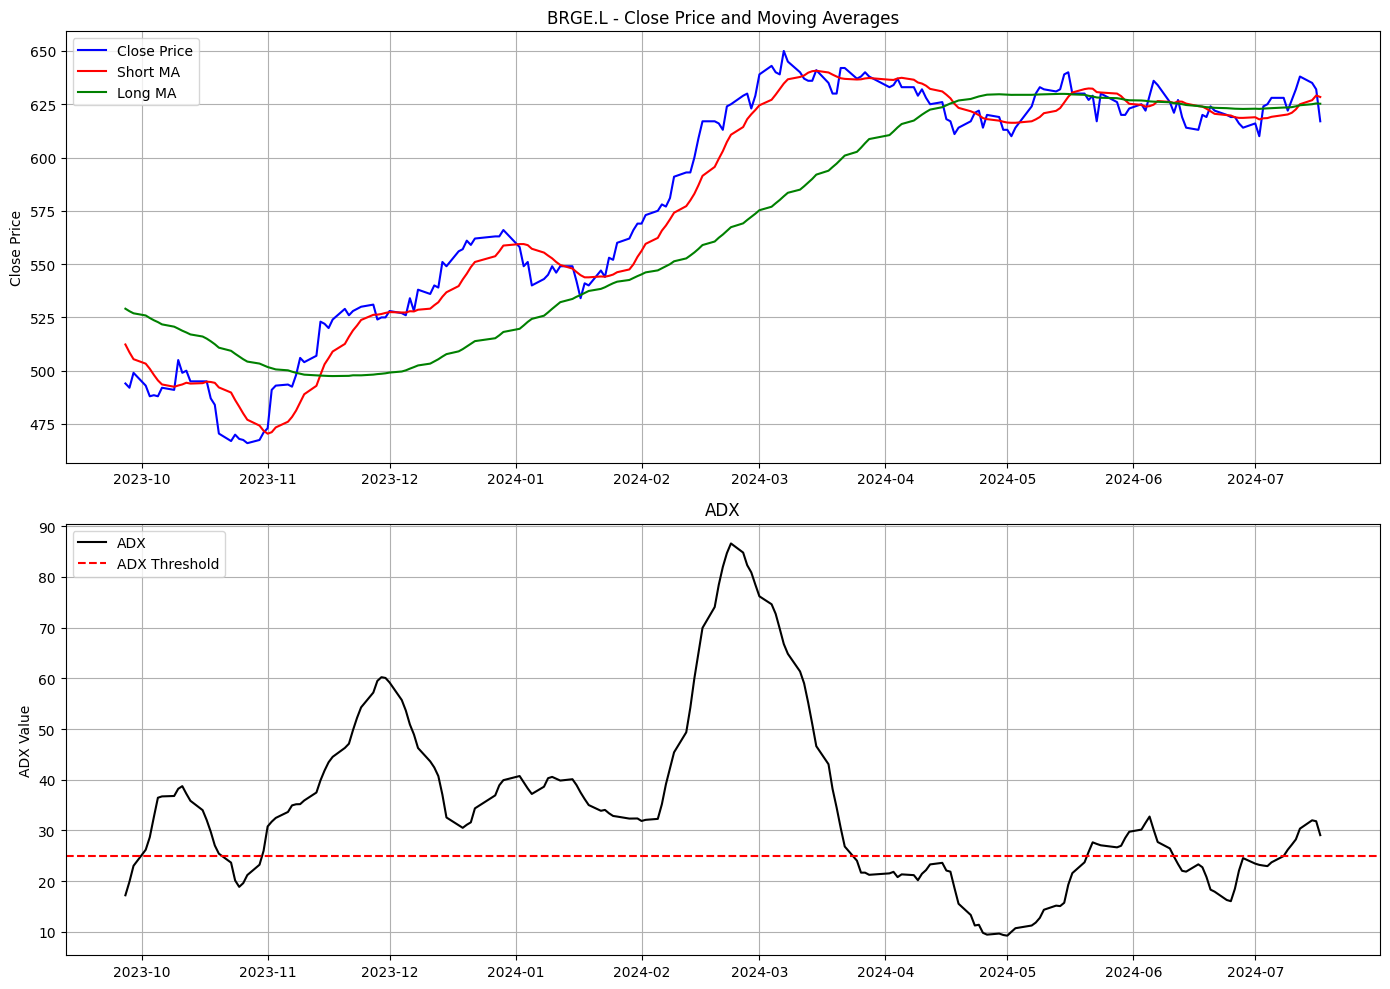

Ticker:                   BRGE.L
Company:                  BLACKROCK GREATER EUROPE INVEST
Sector:                   N/A
Industry:                 N/A
Market Cap:               £603,671,360
Shares Outstanding:       N/A
52-Week High:             671.09
52-Week Low:              457.5
PE Ratio (TTM):           5.2676525
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


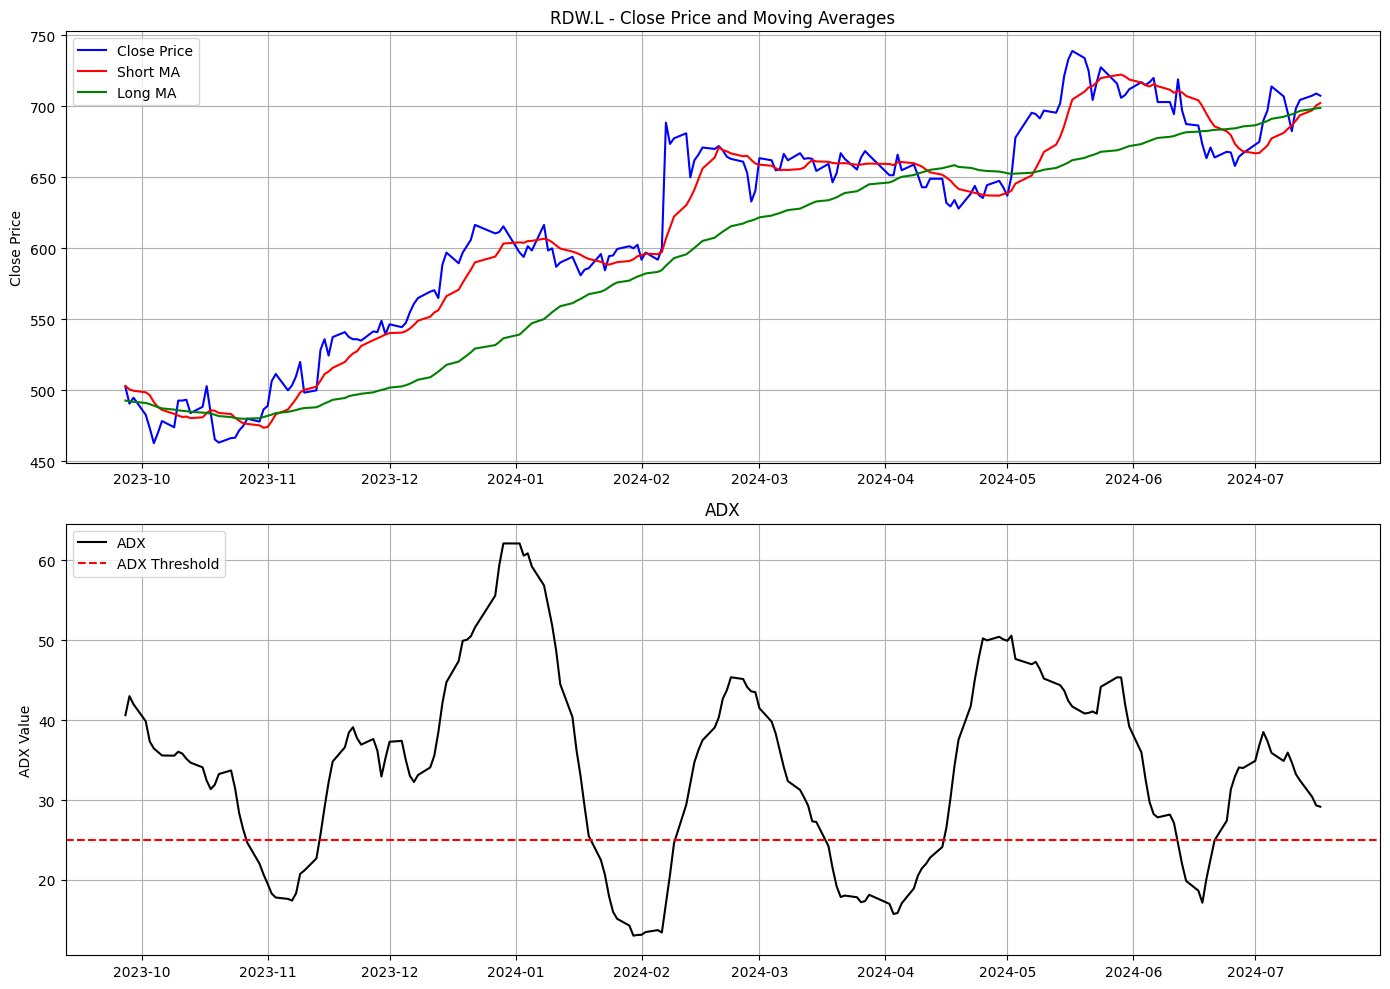

Ticker:                   RDW.L
Company:                  REDROW PLC ORD 10.5P
Sector:                   Consumer Cyclical
Industry:                 Residential Construction
Market Cap:               £2,307,120,640
Shares Outstanding:       330,769,984
52-Week High:             750.0
52-Week Low:              434.6
PE Ratio (TTM):           10.8984375
EPS (TTM):                0.64
Dividend Yield:           0.0352
Payout Ratio:             0.4673
Revenue (TTM):            £1,852,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £208,000,000
Total Debt:               £0
Operating Cash Flow (TTM): £111,000,000
Free Cash Flow (TTM):     £91,875,000

Description:              Redrow plc focuses on housebuilding activities in the United Kingdom. It is involved in acquires, develops, and resells land; develops and sells residential housing properties; and business park maintenance services. Redrow plc was founded in 1974 and is based in Flintshire, the United Kingdom.
---------

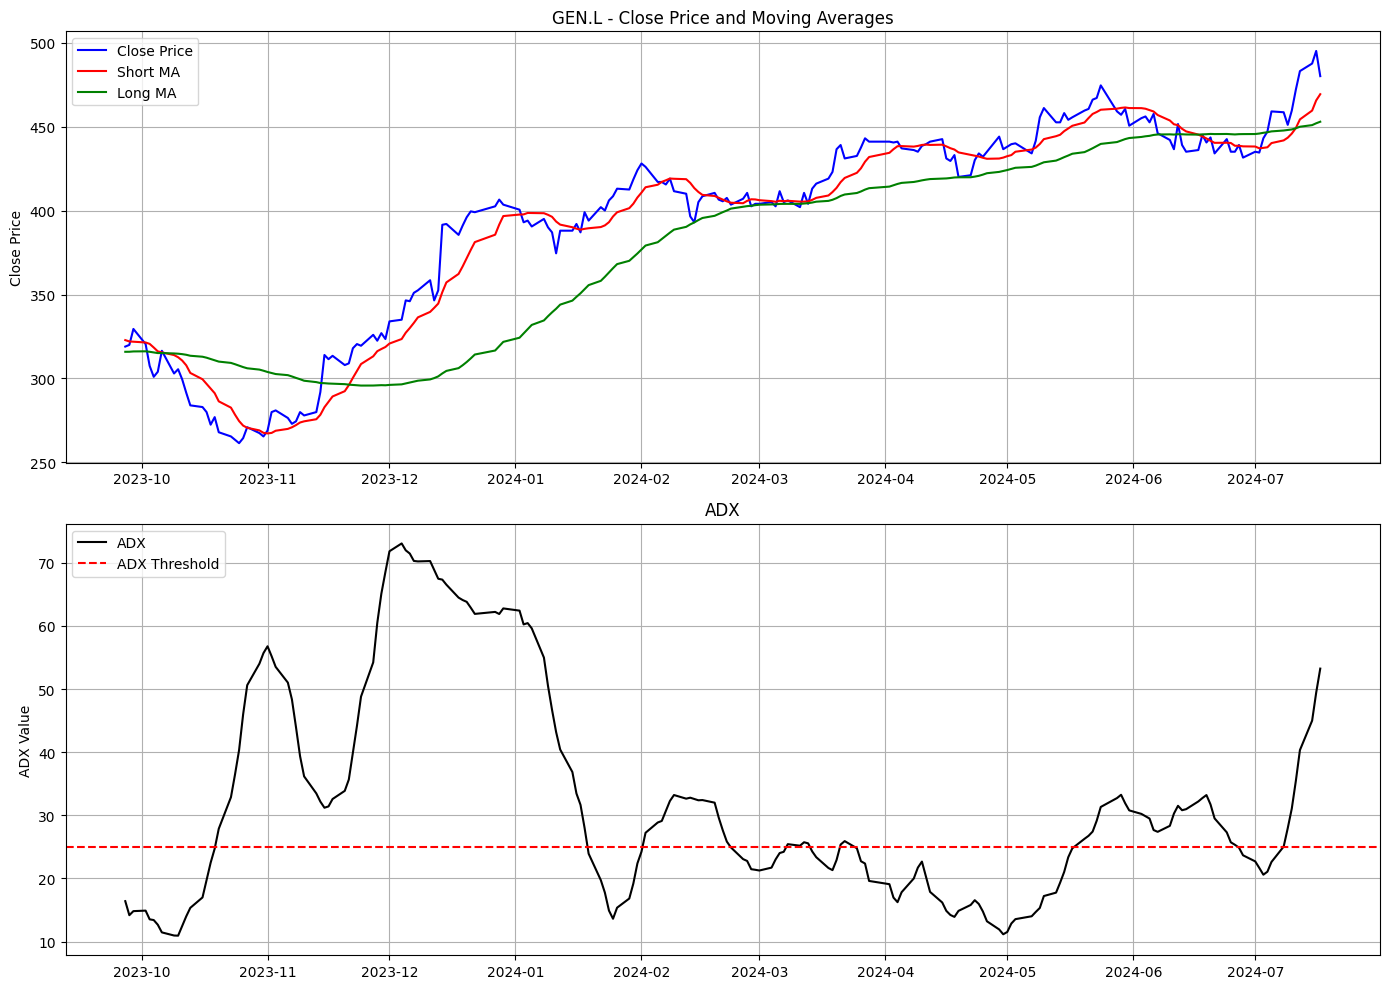

Ticker:                   GEN.L
Company:                  GENUIT GROUP PLC ORD GBP0.001
Sector:                   Industrials
Industry:                 Building Products & Equipment
Market Cap:               £1,213,457,920
Shares Outstanding:       249,170,000
52-Week High:             499.5
52-Week Low:              254.0
PE Ratio (TTM):           32.466663
EPS (TTM):                0.15
Dividend Yield:           0.0255
Payout Ratio:             0.79870003
Revenue (TTM):            £586,499,968
Gross Profit (TTM):       N/A
Net Income (TTM):         £38,500,000
Total Debt:               £166,300,000
Operating Cash Flow (TTM): £97,600,000
Free Cash Flow (TTM):     £57,650,000

Description:              Genuit Group plc develops, manufactures, and sells water, climate, and ventilation management solutions in the United Kingdom, rest of the Europe, and internationally. The company operates through three segments: Sustainable Building Solutions, Water Management Solutions, and Climate Man

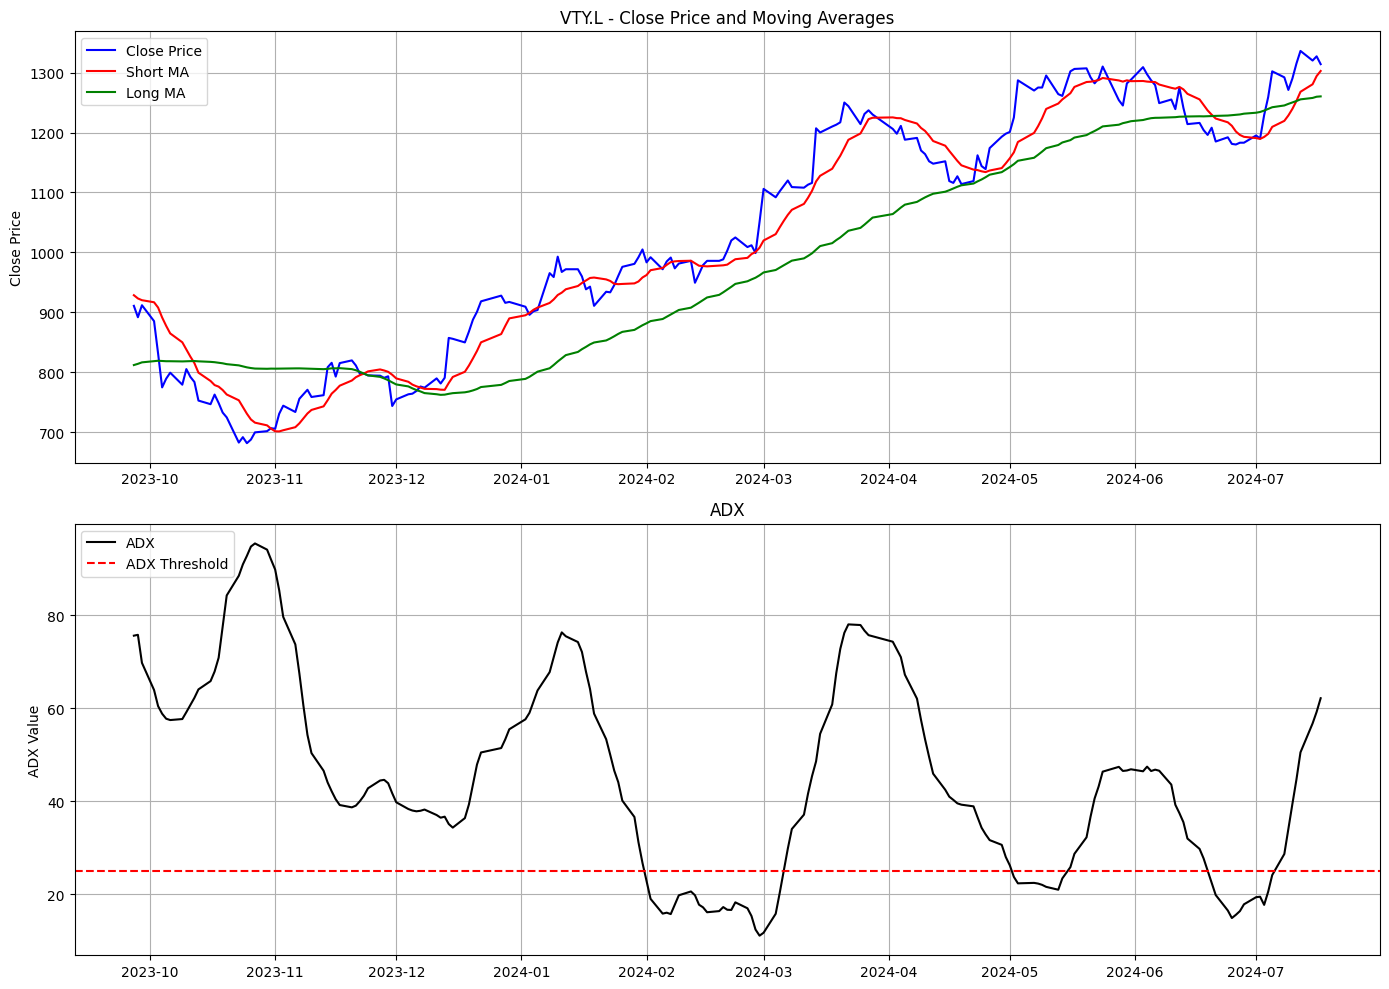

Ticker:                   VTY.L
Company:                  VISTRY GROUP PLC ORD 50P
Sector:                   Consumer Cyclical
Industry:                 Residential Construction
Market Cap:               £4,402,897,920
Shares Outstanding:       336,536,992
52-Week High:             1383.0
52-Week Low:              668.0
PE Ratio (TTM):           20.4375
EPS (TTM):                0.64
Dividend Yield:           N/A
Payout Ratio:             0.50240004
Revenue (TTM):            £3,564,199,936
Gross Profit (TTM):       N/A
Net Income (TTM):         £223,400,000
Total Debt:               £605,400,000
Operating Cash Flow (TTM): £-72,100,000
Free Cash Flow (TTM):     £-24,162,500

Description:              Vistry Group PLC, together with its subsidiaries, provides housing solutions in the United Kingdom. It offers o single family housing model. The company was formerly known as Bovis Homes Group PLC and changed its name to Vistry Group PLC in January 2020. Vistry Group PLC was founded in 1885

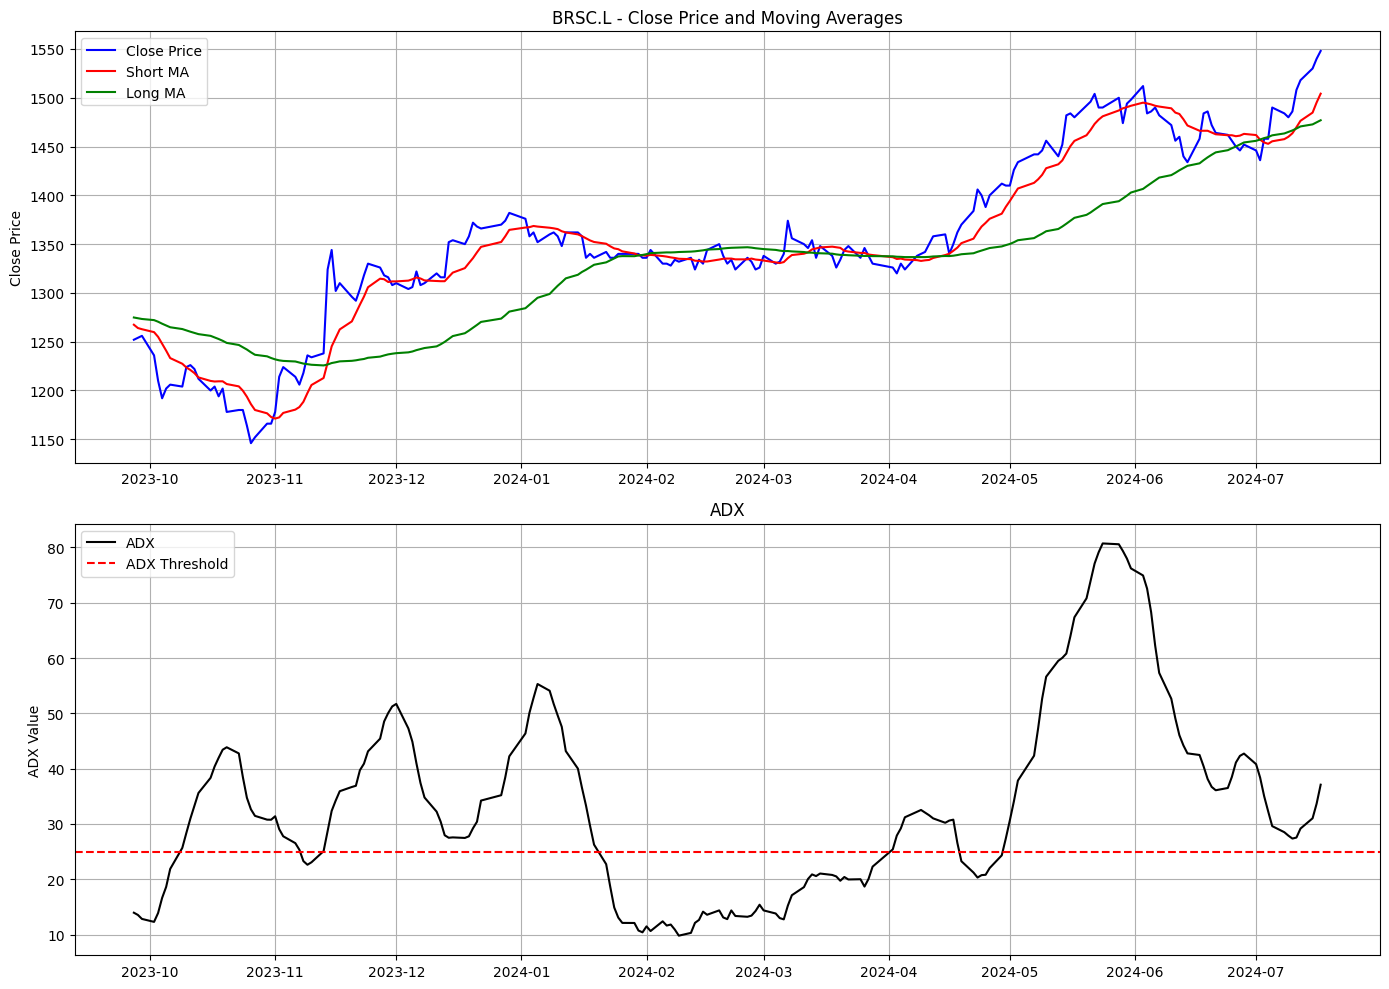

Ticker:                   BRSC.L
Company:                  BLACKROCK SMALLER CO TRUST PLC 
Sector:                   N/A
Industry:                 N/A
Market Cap:               £730,046,848
Shares Outstanding:       N/A
52-Week High:             1568.0
52-Week Low:              1146.0
PE Ratio (TTM):           N/A
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


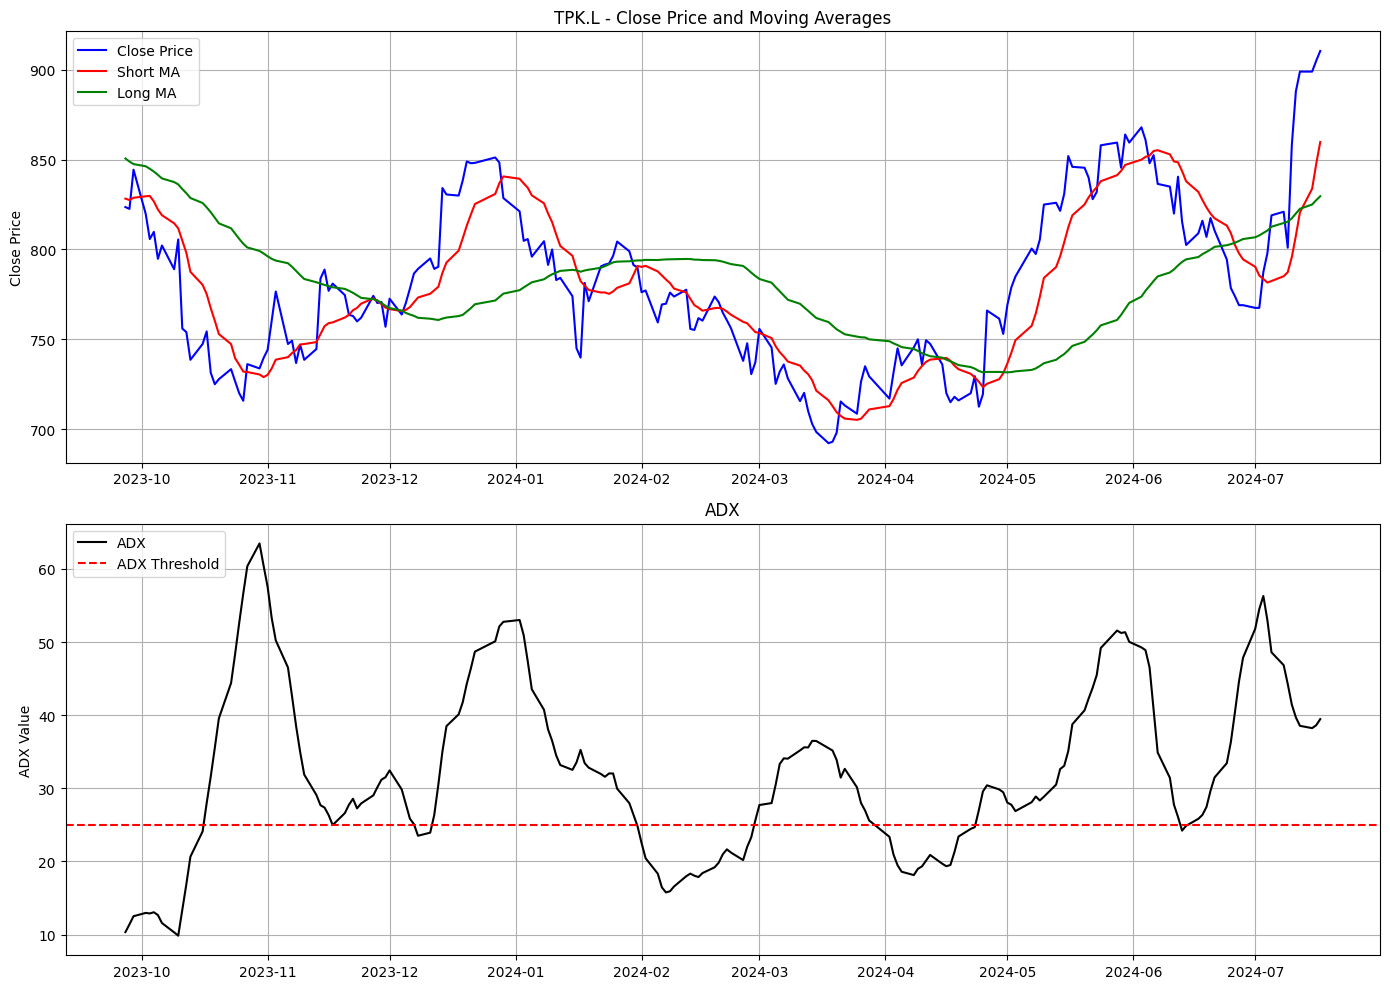

Ticker:                   TPK.L
Company:                  TRAVIS PERKINS PLC
Sector:                   Industrials
Industry:                 Building Products & Equipment
Market Cap:               £1,929,195,008
Shares Outstanding:       210,840,992
52-Week High:             929.0
52-Week Low:              684.8
PE Ratio (TTM):           50.83333
EPS (TTM):                0.18
Dividend Yield:           0.0196
Payout Ratio:             2.191
Revenue (TTM):            £4,861,899,776
Gross Profit (TTM):       N/A
Net Income (TTM):         £38,100,000
Total Debt:               £1,053,500,032
Operating Cash Flow (TTM): £217,600,000
Free Cash Flow (TTM):     £114,362,496

Description:              Travis Perkins plc engages in distribution of building material products in the United Kingdom. It operates through Merchanting and Toolstation segments. The company offers tools and building supplies. It also distributes pipeline products, as well as supplies managed services, and commercial and i

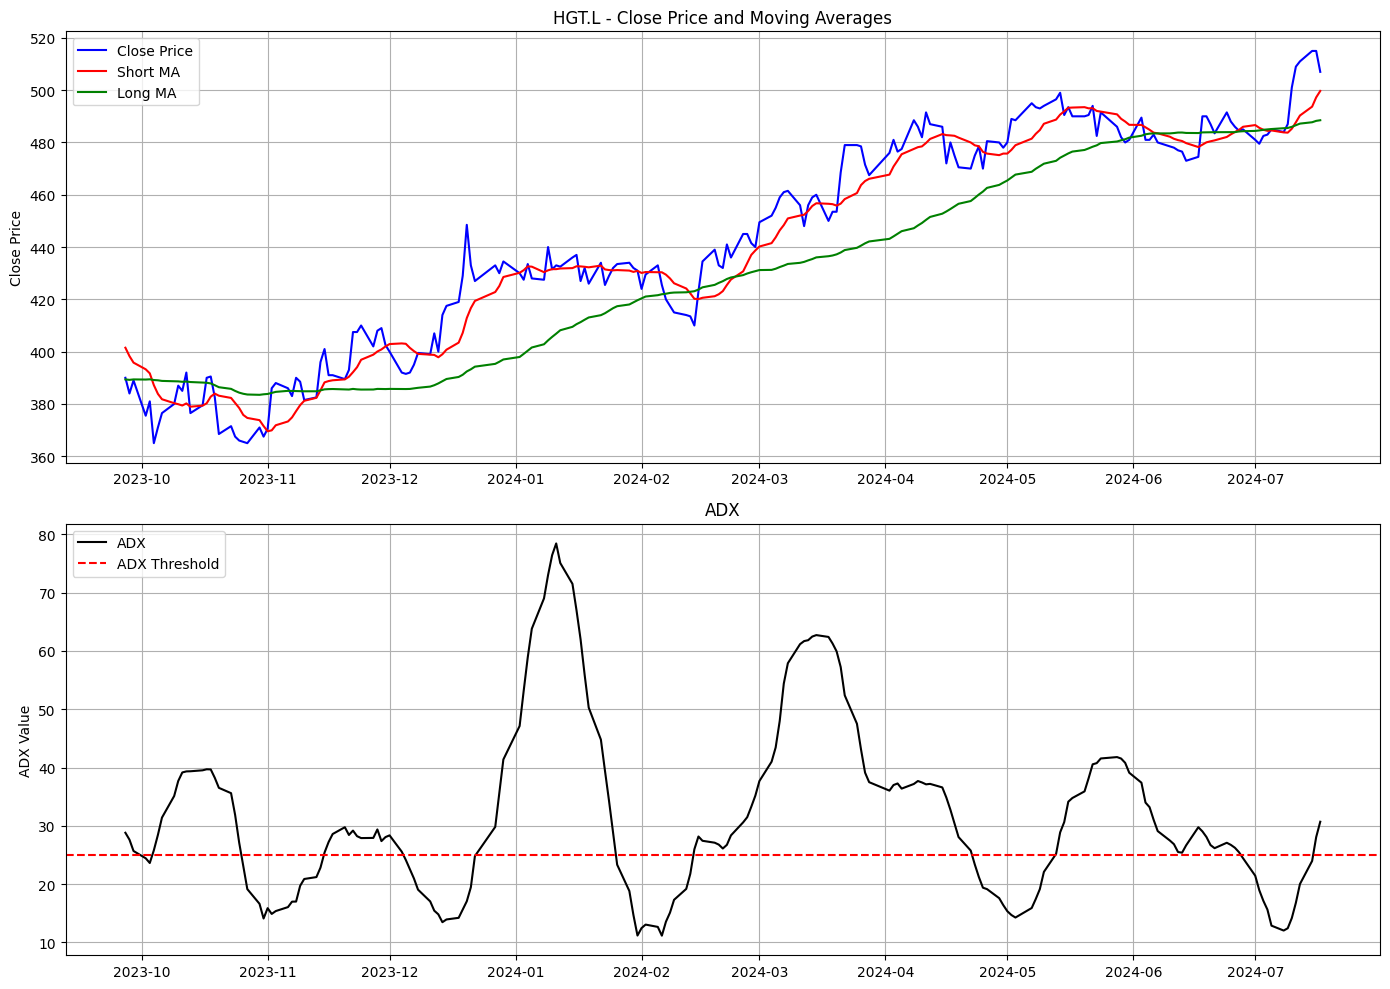

Ticker:                   HGT.L
Company:                  HG CAPITAL TRUST PLC ORD 2.5P
Sector:                   N/A
Industry:                 N/A
Market Cap:               £2,321,734,912
Shares Outstanding:       N/A
52-Week High:             517.0
52-Week Low:              357.0
PE Ratio (TTM):           10.144584
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


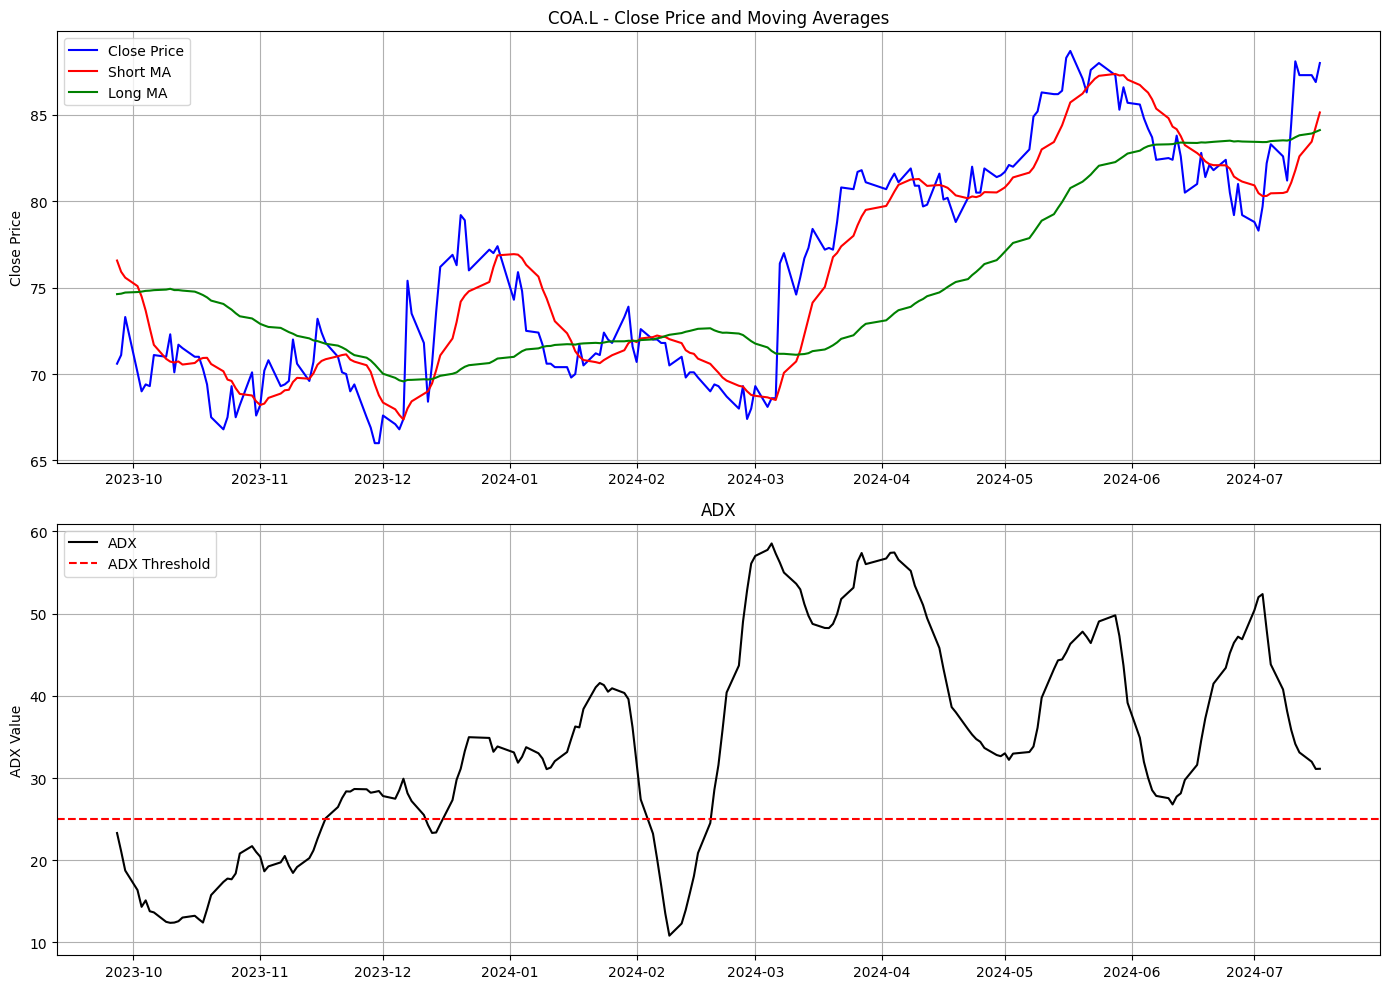

Ticker:                   COA.L
Company:                  COATS GROUP PLC ORD 5P
Sector:                   Consumer Cyclical
Industry:                 Textile Manufacturing
Market Cap:               £1,385,088,640
Shares Outstanding:       1,591,689,984
52-Week High:             89.6
52-Week Low:              64.3
PE Ratio (TTM):           21.755
EPS (TTM):                0.04
Dividend Yield:           0.025
Payout Ratio:             0.4951
Revenue (TTM):            £1,394,200,064
Gross Profit (TTM):       N/A
Net Income (TTM):         £83,200,000
Total Debt:               £603,299,968
Operating Cash Flow (TTM): £123,900,000
Free Cash Flow (TTM):     £196,350,000

Description:              Coats Group plc, together with its subsidiaries, manufactures and supplies industrial sewing threads worldwide. The company provides threads, yarns, zips, trims, composites, and fabrics for use in apparel, such as children's wear, denims, intimate and underwear, ladieswear, leather wear, menswear, sp

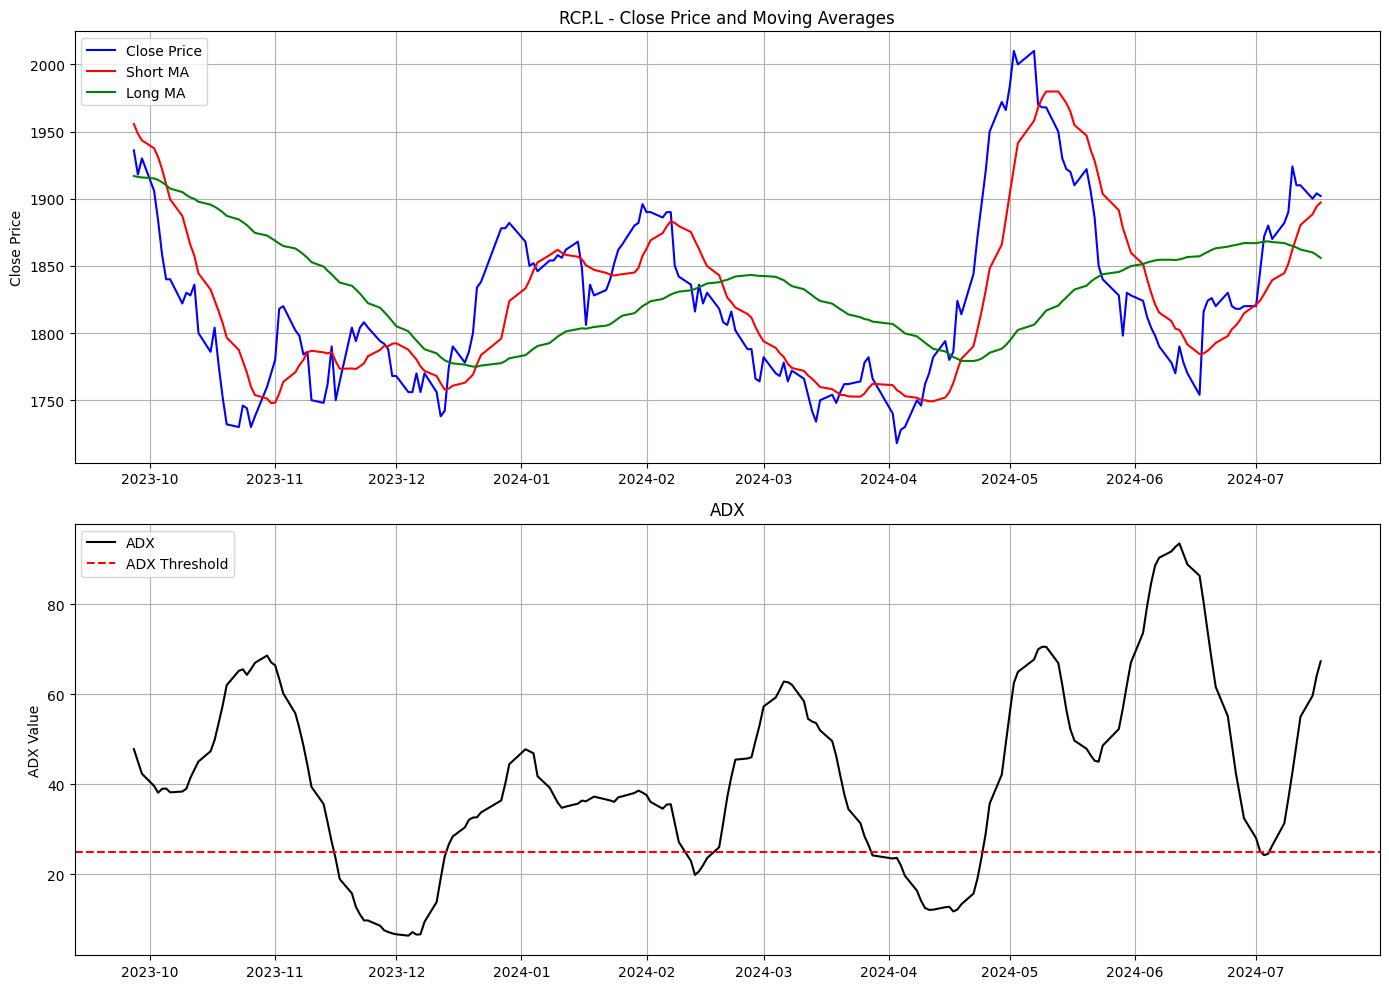

Ticker:                   RCP.L
Company:                  RIT CAPITAL PARTNERS PLC
Sector:                   N/A
Industry:                 N/A
Market Cap:               £2,719,270,912
Shares Outstanding:       N/A
52-Week High:             2426.0
52-Week Low:              1696.0
PE Ratio (TTM):           42.89098
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


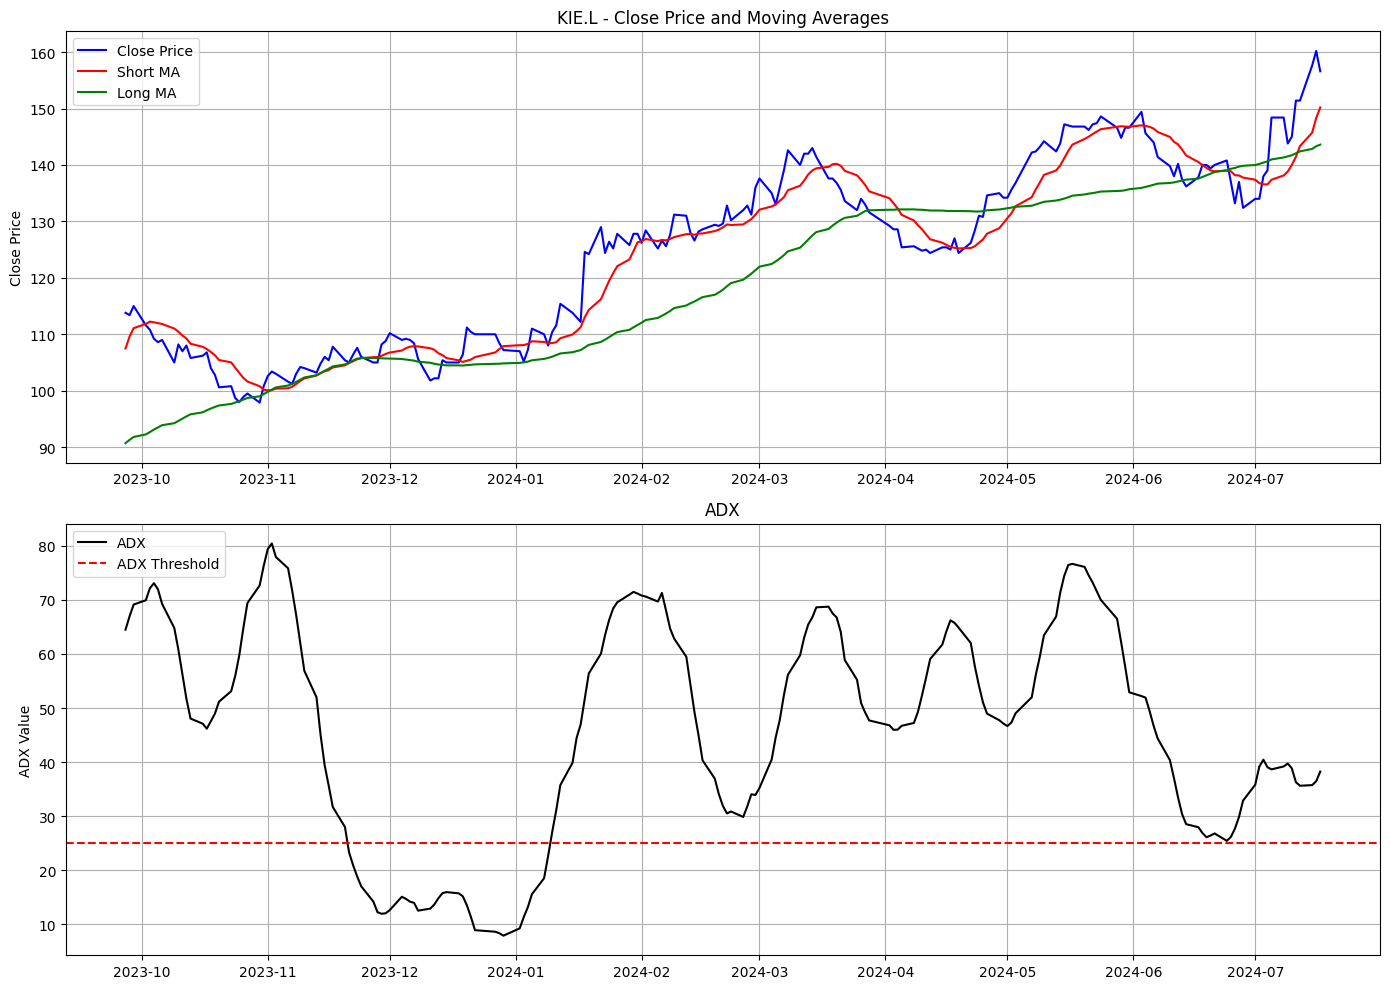

Ticker:                   KIE.L
Company:                  KIER GROUP PLC ORD 1P
Sector:                   Industrials
Industry:                 Engineering & Construction
Market Cap:               £708,747,200
Shares Outstanding:       452,134,016
52-Week High:             163.268
52-Week Low:              81.1
PE Ratio (TTM):           17.417332
EPS (TTM):                0.09
Dividend Yield:           0.0208
Payout Ratio:             0.0
Revenue (TTM):            £3,716,999,936
Gross Profit (TTM):       N/A
Net Income (TTM):         £40,200,000
Total Debt:               £490,400,000
Operating Cash Flow (TTM): £273,100,000
Free Cash Flow (TTM):     £253,024,992

Description:              Kier Group plc primarily engages in the construction business in the United Kingdom and internationally. The company operates through three segments: Construction, Infrastructure Services, and Property. It constructs power stations, roads, bridges, railways, tunnels, and buildings for public and privat

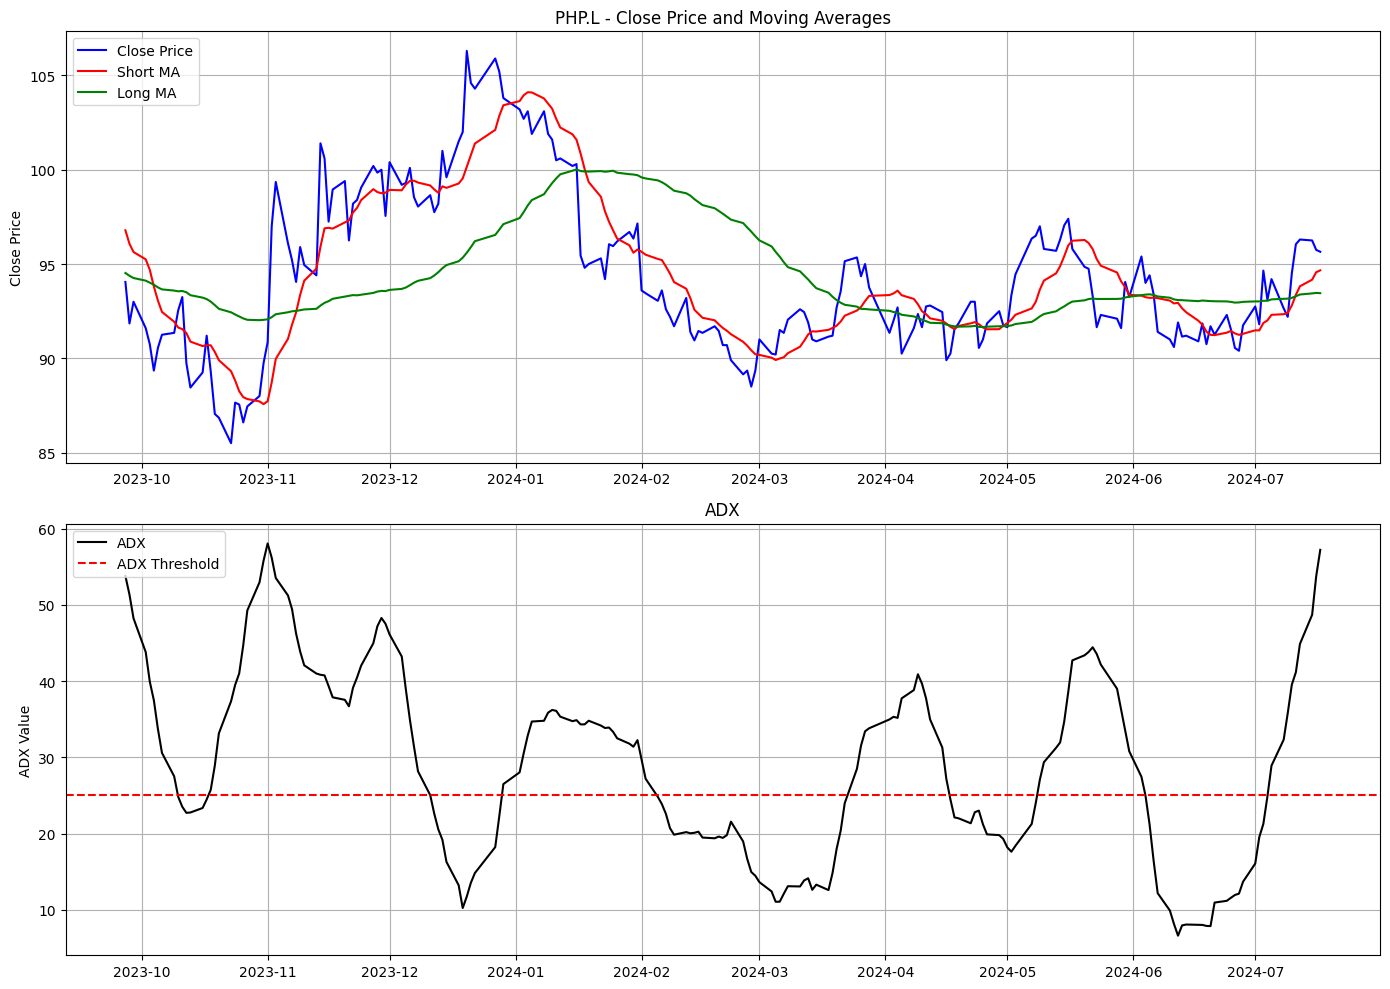

Ticker:                   PHP.L
Company:                  PRIMARY HEALTH PROPERTIES PLC O
Sector:                   Real Estate
Industry:                 REIT - Healthcare Facilities
Market Cap:               £1,266,844,928
Shares Outstanding:       1,335,629,952
52-Week High:             109.0
52-Week Low:              84.2
PE Ratio (TTM):           47.425
EPS (TTM):                0.02
Dividend Yield:           0.0718
Payout Ratio:             3.35
Revenue (TTM):            £169,800,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £27,300,000
Total Debt:               £1,332,999,936
Operating Cash Flow (TTM): £133,600,000
Free Cash Flow (TTM):     £49,575,000

Description:              Primary Health Properties (PHP) is the leading investor in modern healthcare properties in the UK & Ireland. PHP is a UK based Real Estate Investment Trust (REIT) with a clear objective to create progressive returns to shareholders through a combination of earnings growth and capital appreci

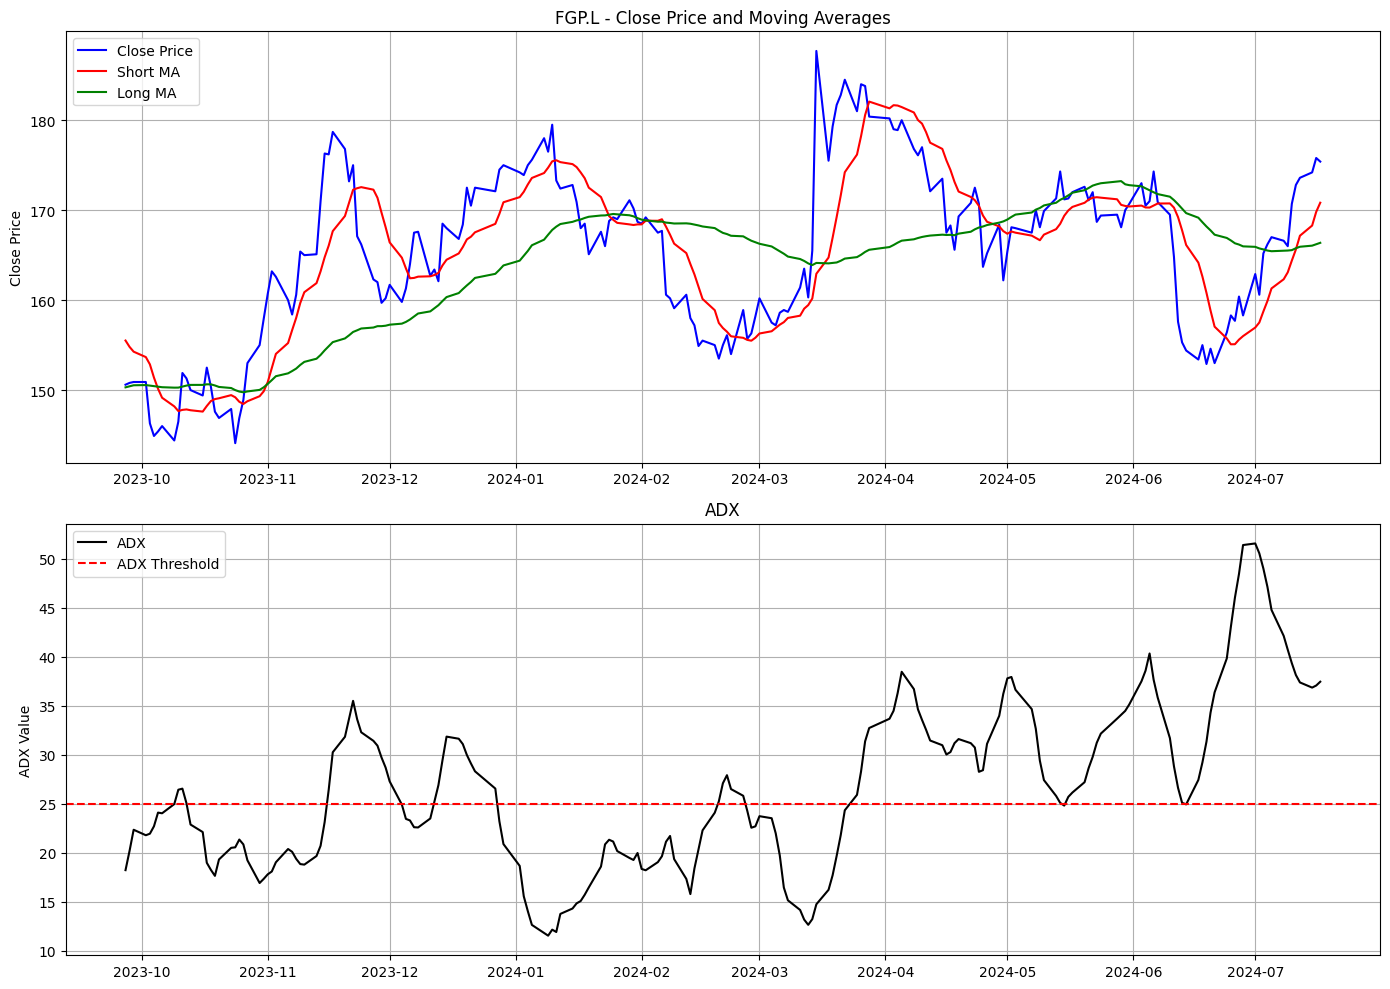

Ticker:                   FGP.L
Company:                  FIRSTGROUP PLC ORD 5P
Sector:                   Industrials
Industry:                 Railroads
Market Cap:               £1,034,901,184
Shares Outstanding:       603,608,000
52-Week High:             189.0
52-Week Low:              135.0
PE Ratio (TTM):           N/A
EPS (TTM):                -0.02
Dividend Yield:           0.0321
Payout Ratio:             0.1942
Revenue (TTM):            £4,715,100,160
Gross Profit (TTM):       N/A
Net Income (TTM):         £-10,200,000
Total Debt:               £1,645,299,968
Operating Cash Flow (TTM): £543,299,968
Free Cash Flow (TTM):     £445,362,496

Description:              FirstGroup plc provides public transport services in the United Kingdom. The company operates through First Bus and First Rail segments. The First Bus segment offers local bus services with a fleet of approximately 4,800 buses in the United Kingdom. The First Rail segment operates a passenger rail network that provid

In [44]:
# Function to print basic financial data
def print_financial_data(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    def format_value(value, currency=False):
        if isinstance(value, (int, float)):
            formatted_value = f"{value:,}"
            if currency:
                formatted_value = f"£{formatted_value}"
            return formatted_value
        return value

    market_cap = format_value(info.get('marketCap', 'N/A'), currency=True)
    shares_outstanding = format_value(info.get('sharesOutstanding', 'N/A'))
    year_high = info.get('fiftyTwoWeekHigh', 'N/A')
    year_low = info.get('fiftyTwoWeekLow', 'N/A')
    pe_ratio = info.get('trailingPE', 'N/A')
    eps = info.get('trailingEps', 'N/A')
    dividend_yield = info.get('dividendYield', 'N/A')
    payout_ratio = info.get('payoutRatio', 'N/A')
    revenue = format_value(info.get('totalRevenue', 'N/A'), currency=True)
    gross_profit = format_value(info.get('grossProfits', 'N/A'), currency=True)
    net_income = format_value(info.get('netIncomeToCommon', 'N/A'), currency=True)
    total_debt = format_value(info.get('totalDebt', 'N/A'), currency=True)
    operating_cash_flow = format_value(info.get('operatingCashflow', 'N/A'), currency=True)
    free_cash_flow = format_value(info.get('freeCashflow', 'N/A'), currency=True)
    sector = info.get('sector', 'N/A')
    industry = info.get('industry', 'N/A')
    description = info.get('longBusinessSummary', 'N/A')

    print(f"{'Ticker:':<25} {ticker}")
    print(f"{'Company:':<25} {info.get('shortName', 'N/A')}")
    print(f"{'Sector:':<25} {sector}")
    print(f"{'Industry:':<25} {industry}")
    print(f"{'Market Cap:':<25} {market_cap}")
    print(f"{'Shares Outstanding:':<25} {shares_outstanding}")
    print(f"{'52-Week High:':<25} {year_high}")
    print(f"{'52-Week Low:':<25} {year_low}")
    print(f"{'PE Ratio (TTM):':<25} {pe_ratio}")
    print(f"{'EPS (TTM):':<25} {eps}")
    print(f"{'Dividend Yield:':<25} {dividend_yield}")
    print(f"{'Payout Ratio:':<25} {payout_ratio}")
    print(f"{'Revenue (TTM):':<25} {revenue}")
    print(f"{'Gross Profit (TTM):':<25} {gross_profit}")
    print(f"{'Net Income (TTM):':<25} {net_income}")
    print(f"{'Total Debt:':<25} {total_debt}")
    print(f"{'Operating Cash Flow (TTM):':<25} {operating_cash_flow}")
    print(f"{'Free Cash Flow (TTM):':<25} {free_cash_flow}")
    print(f"\n{'Description:':<25} {description}")  # Print the full description
    print("-" * 50)

# Function to plot MA and ADX indicators
def plot_ma_adx(data, symbol):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Plot Close Price and Moving Averages
    ax1.plot(data.index, data['Close'], label='Close Price', color='blue')
    ax1.plot(data.index, data['Short_MA'], label='Short MA', color='red')
    ax1.plot(data.index, data['Long_MA'], label='Long MA', color='green')
    ax1.set_title(f'{symbol} - Close Price and Moving Averages')
    ax1.set_ylabel('Close Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Plot ADX
    ax2.plot(data.index, data['ADX'], label='ADX', color='black')
    ax2.axhline(y=25, color='r', linestyle='--', label='ADX Threshold')
    ax2.set_title('ADX')
    ax2.set_ylabel('ADX Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

print("The following stocks have met the specified criteria. A plot is displayed showing the stock price and its relationship to the associated indicators. Additionally, detailed financial and company information is provided for each stock.\n")


# Iterate through all tickers to plot graphs and print financial data
for stock_data in results:
    symbol = stock_data["Symbol"]
    data = stock_data["Data"]
    plot_ma_adx(data, symbol)
    print_financial_data(symbol)
